# NARDI historical phenotypic wheat data analysis

## Load packages, custom functions and data

In [1]:
library(readxl)
library(tidyverse)
library(multtest)
library(asreml)

source("../custom_functions.r")

── Attaching core tidyverse packages ────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame,

Online License checked out Mon Apr 22 16:36:57 2024


In [2]:
data_total <- preprocess("NARDI_Phenotypic_Historical_Winter_Wheat.xlsx")
write_csv(data_total, "NARDI_wheat.csv")
genotypes <- distinct(data_total["accenumb"]) |> rename("genotype" = "accenumb")
cat("Wheat data:\n", nrow(data_total), "observations\n", nrow(genotypes), "genotypes\n", nrow(distinct(data_total["campaign"])), "campaigns\n\n")
summary(data_total[c("days_to_heading", "plant_height", "thousand_kernel_weight")])

Wheat data:
 4267 observations
 750 genotypes
 40 campaigns



 days_to_heading  plant_height    thousand_kernel_weight
 Min.   :110.0   Min.   : 50.00   Min.   :22.50         
 1st Qu.:134.0   1st Qu.: 82.78   1st Qu.:39.60         
 Median :138.0   Median : 93.40   Median :43.71         
 Mean   :138.9   Mean   : 92.99   Mean   :43.51         
 3rd Qu.:143.0   3rd Qu.:103.00   3rd Qu.:47.60         
 Max.   :264.0   Max.   :150.00   Max.   :78.00         
                 NA's   :561      NA's   :2605          

In [3]:
data_total |> head()

accenumb,agent_id,doi,days_to_heading,plant_height,plant_density,thousand_kernel_weight,hectolitric_weight,dry_matter_yield,lodging,leaf_rust,stripe_rust,septoria,powdery_mildew,name,description,campaign
<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
CGF-224,NA,NA,141,100,NA,NA,NA,2960,1,6,NA,NA,3,Fundulea,Winter wheat,1968-1969
CGF-2616,NA,NA,141,95,NA,NA,NA,3800,1,2,NA,NA,2,Fundulea,Winter wheat,1968-1969
CGF-2617,NA,NA,141,90,NA,NA,NA,3440,1,1,NA,NA,2,Fundulea,Winter wheat,1968-1969
CGF-375,NA,NA,147,105,NA,NA,NA,2910,5,6,NA,NA,3,Fundulea,Winter wheat,1968-1969
CGF-6971,NA,NA,144,75,NA,NA,NA,3520,1,4,NA,NA,2,Fundulea,Winter wheat,1968-1969
CGF-1546,NA,NA,140,125,NA,NA,NA,3370,NA,NA,NA,NA,NA,Fundulea,Winter wheat,1969-1970


## Subset data, remove missing values and singletons, make factors

In [4]:
data_sub_HT <- data_total |> make_data_sub("days_to_heading")
data_sub_PH <- data_total |> make_data_sub("plant_height")
data_sub_PD <- data_total |> make_data_sub("plant_density")
data_sub_TKW <- data_total |> make_data_sub("thousand_kernel_weight")
data_sub_HW <- data_total |> make_data_sub("hectolitric_weight")
data_sub_DMY <- data_total |> make_data_sub("dry_matter_yield")
data_sub_L <- data_total |> make_data_sub("lodging")
data_sub_LR <- data_total |> make_data_sub("leaf_rust")
data_sub_SR <- data_total |> make_data_sub("stripe_rust")
data_sub_ST <- data_total |> make_data_sub("septoria")
data_sub_PM <- data_total |> make_data_sub("powdery_mildew")

1812 days_to_heading rows kept
2193 plant_height rows kept
1732 plant_density rows kept
1081 thousand_kernel_weight rows kept
746 hectolitric_weight rows kept
2532 dry_matter_yield rows kept
633 lodging rows kept
564 leaf_rust rows kept
256 stripe_rust rows kept
662 septoria rows kept
1088 powdery_mildew rows kept


## Visualise trait values 

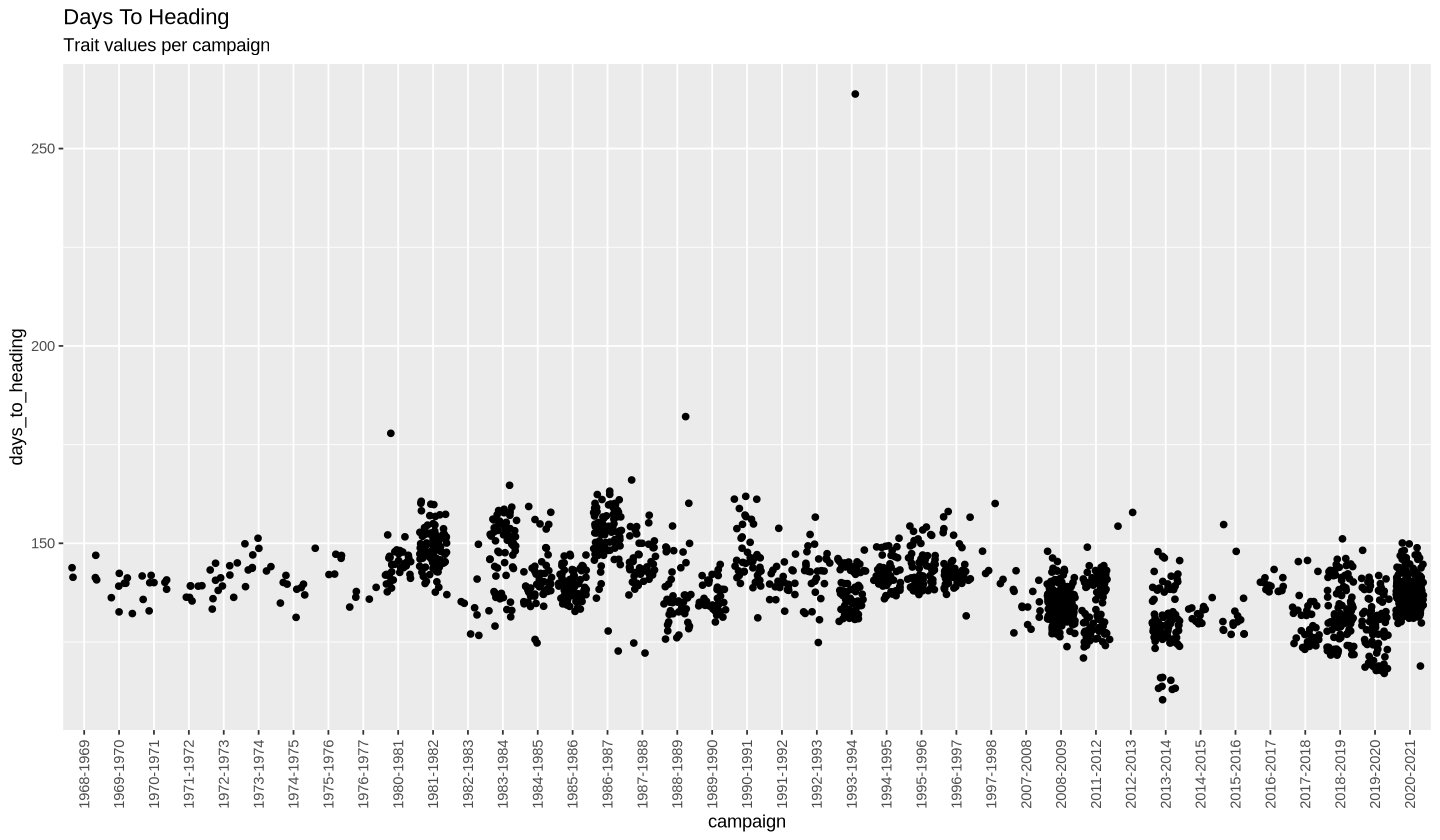

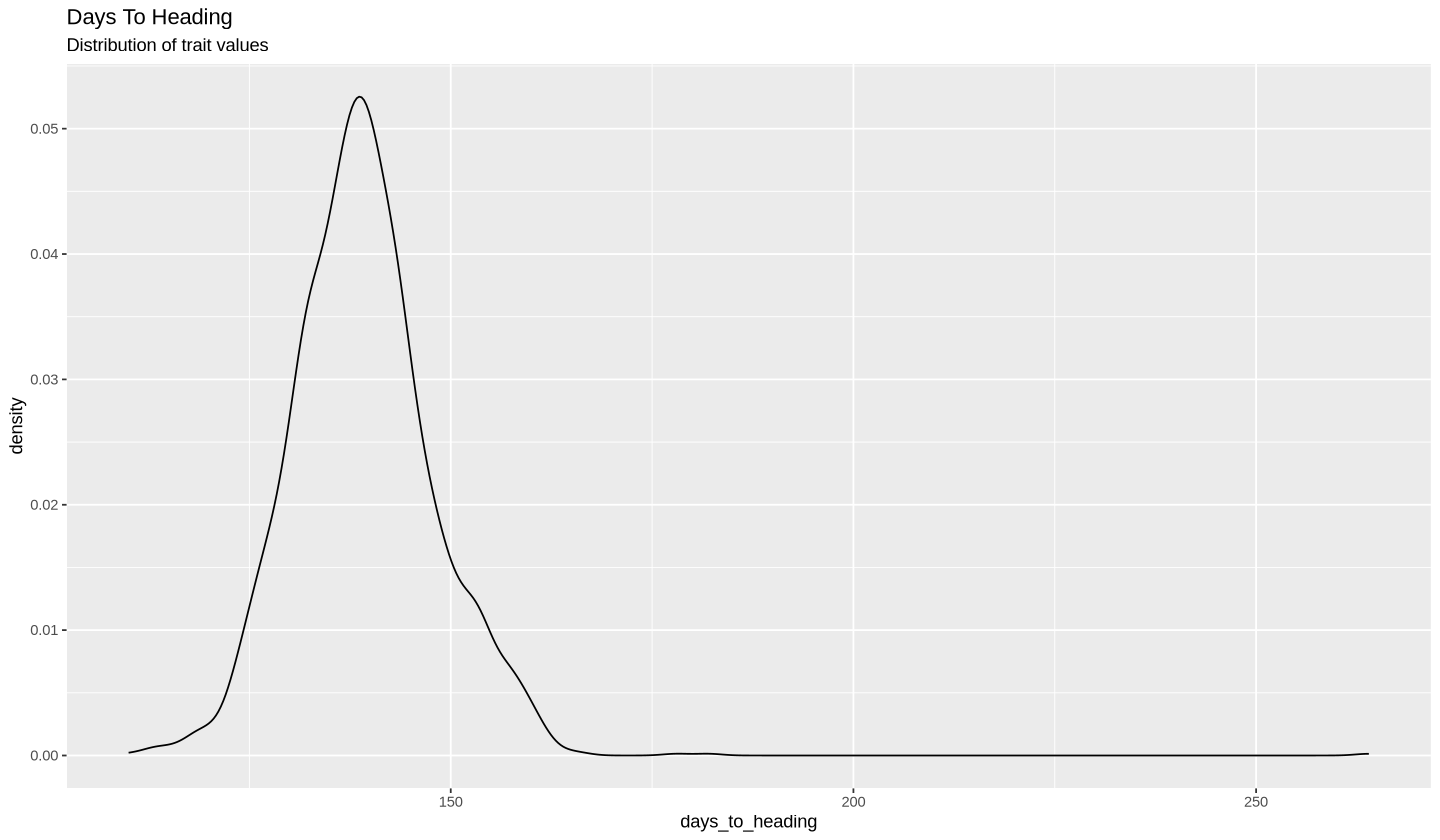

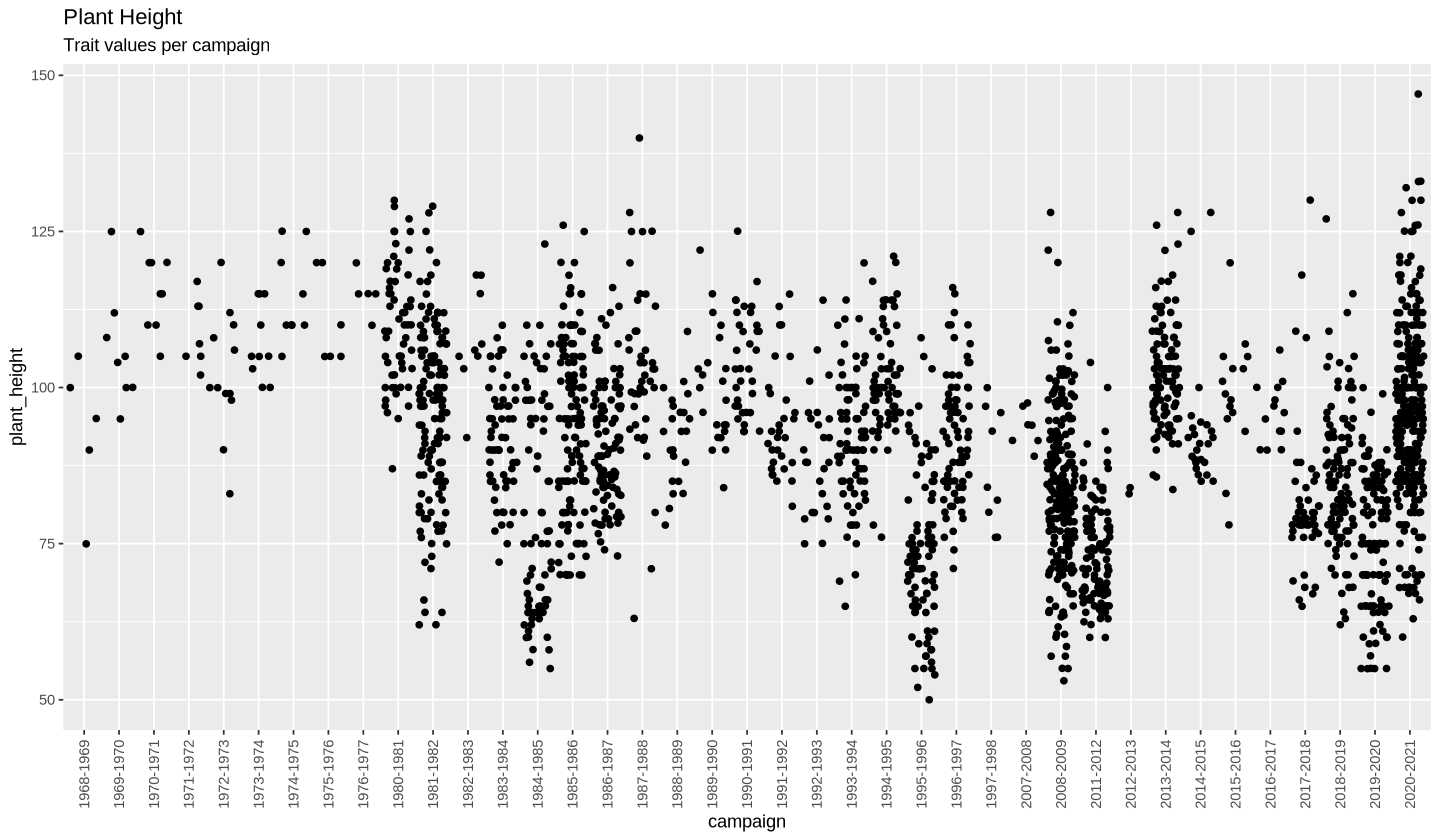

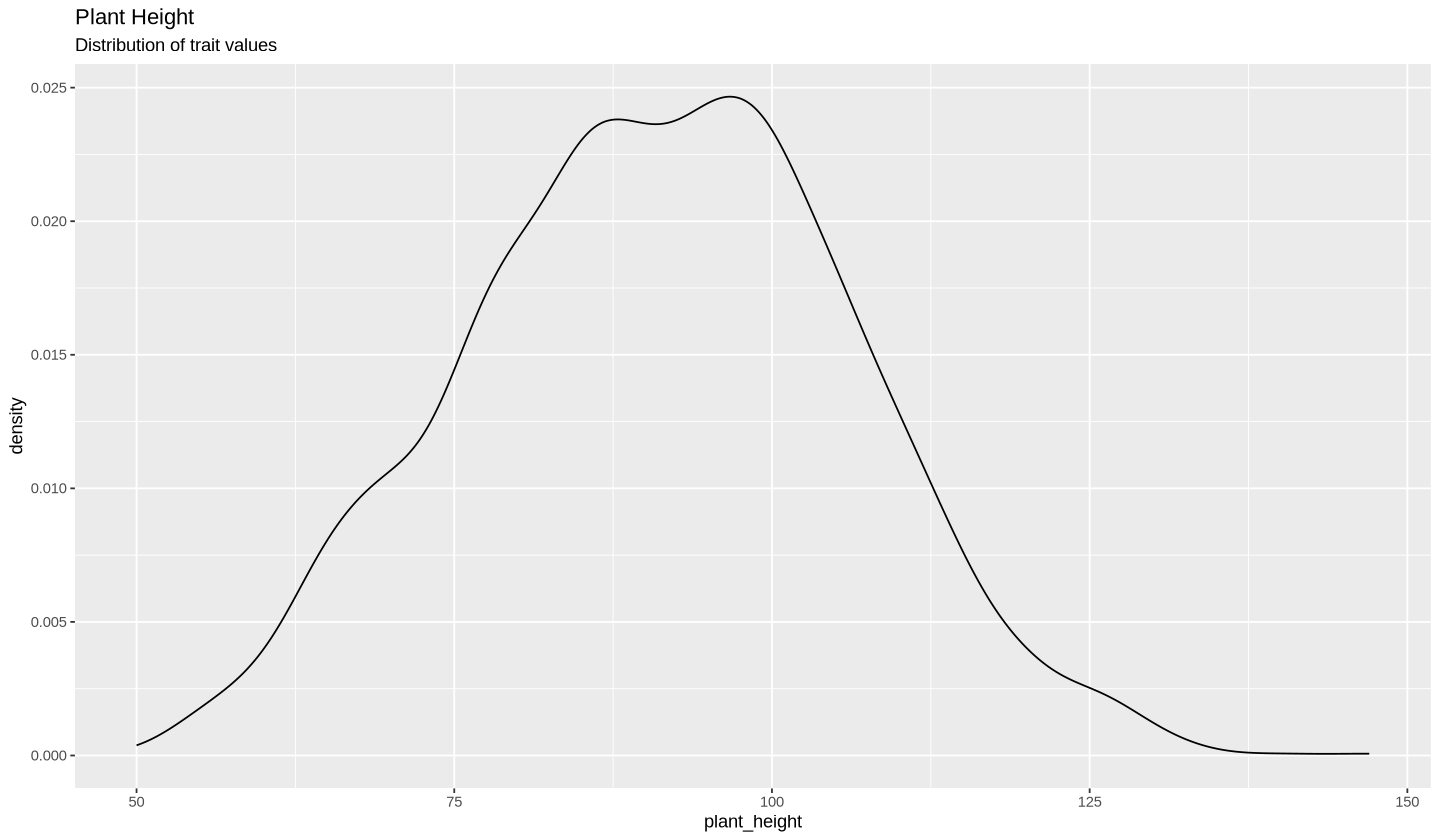

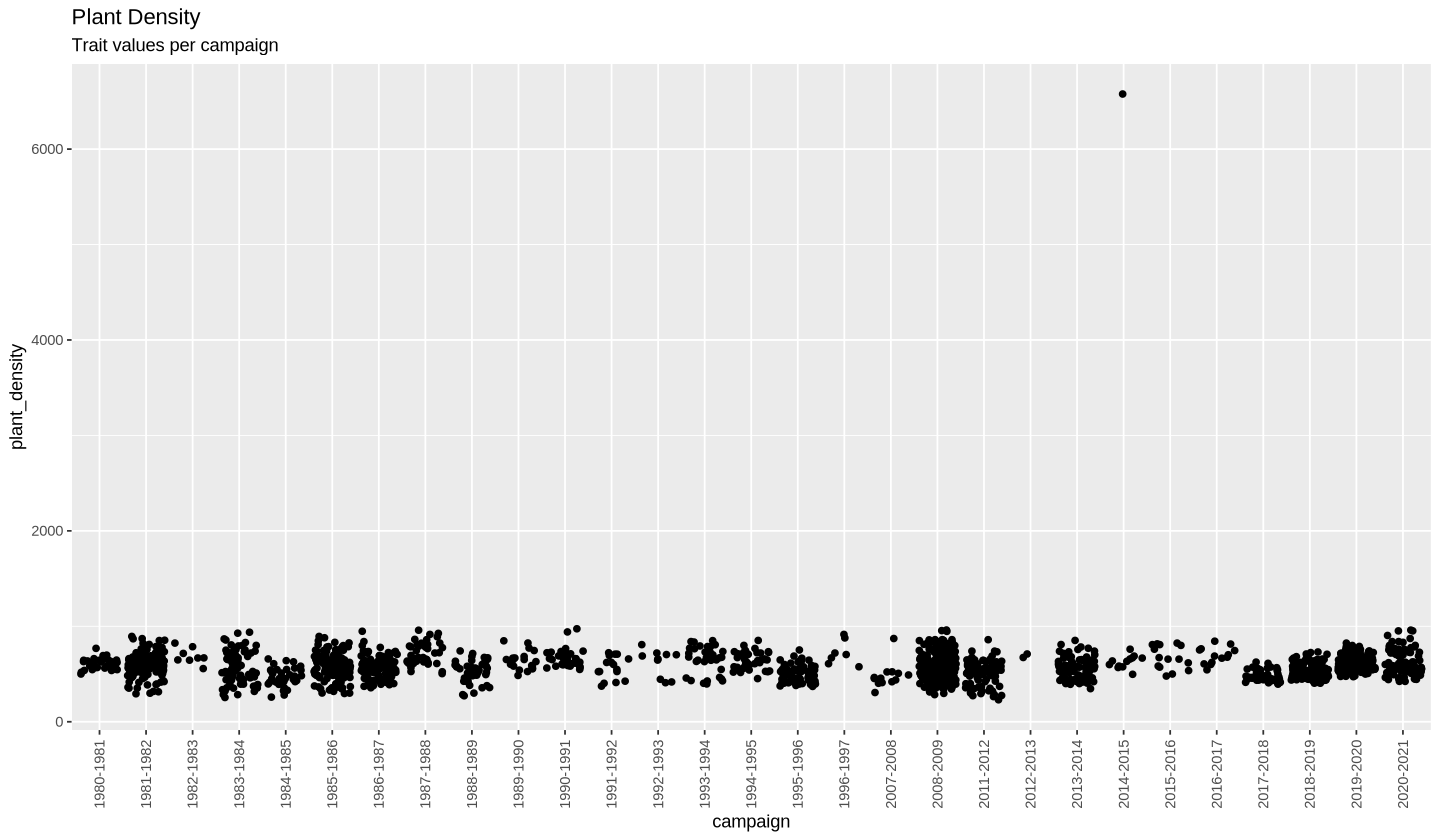

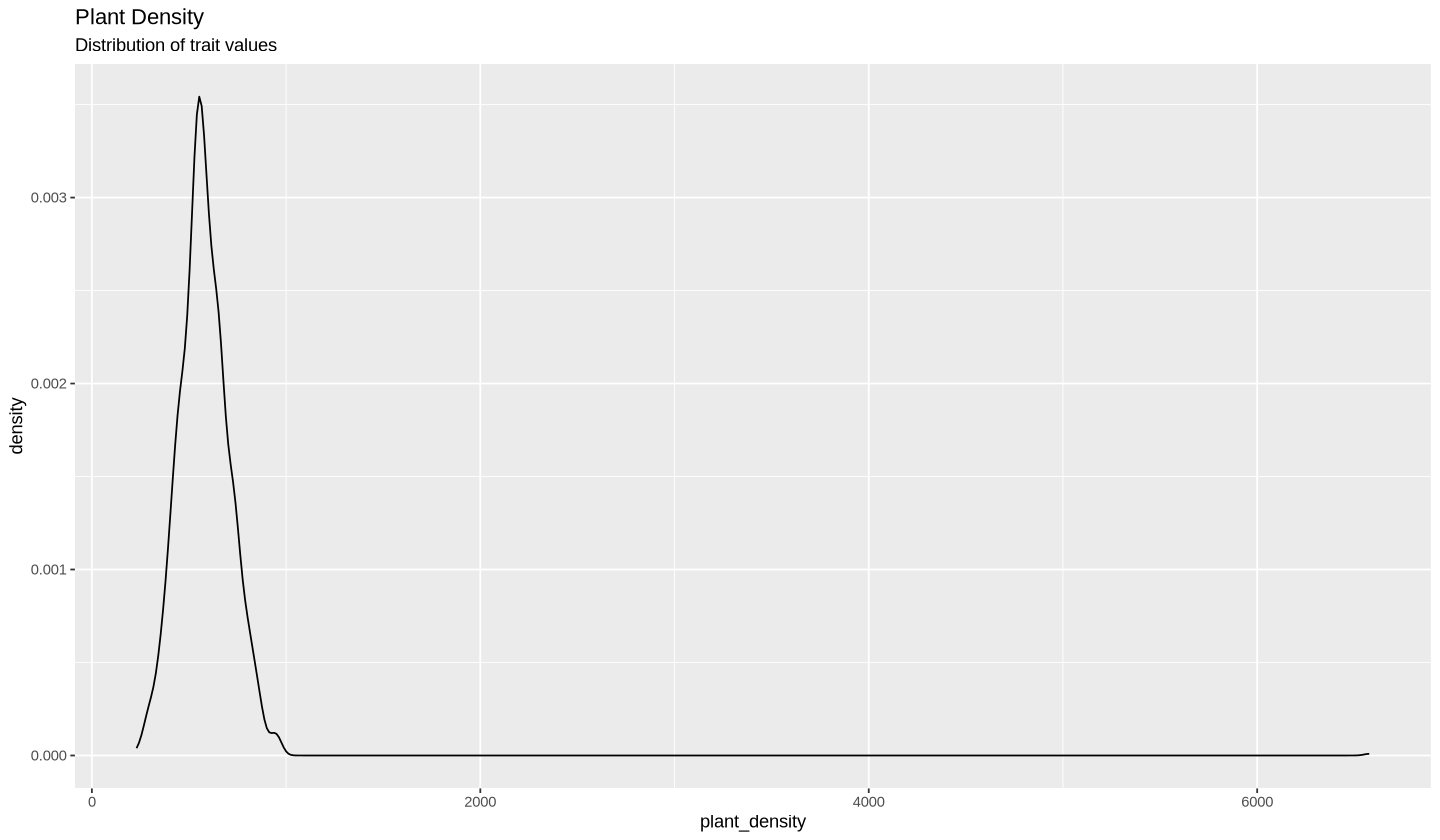

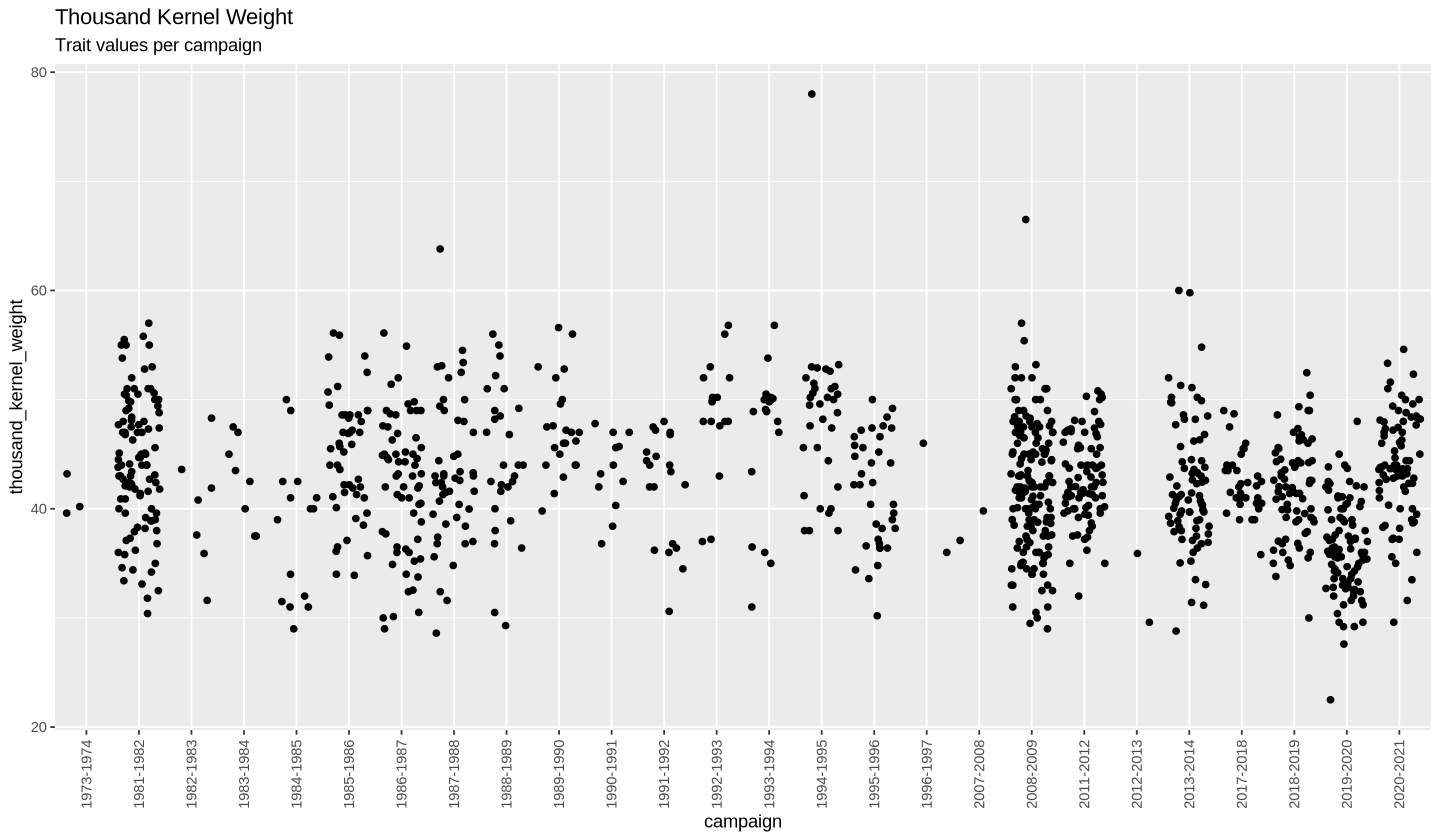

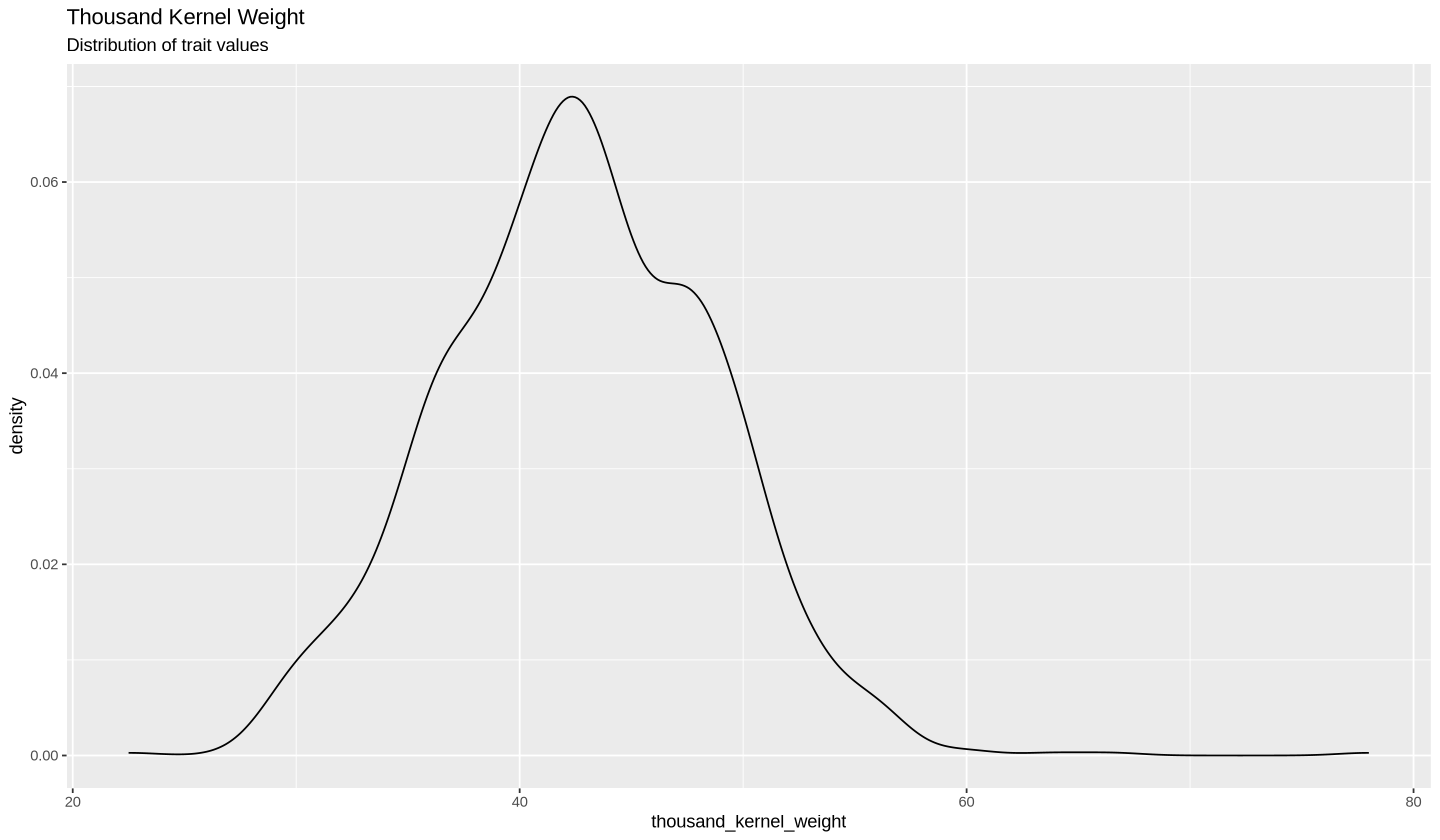

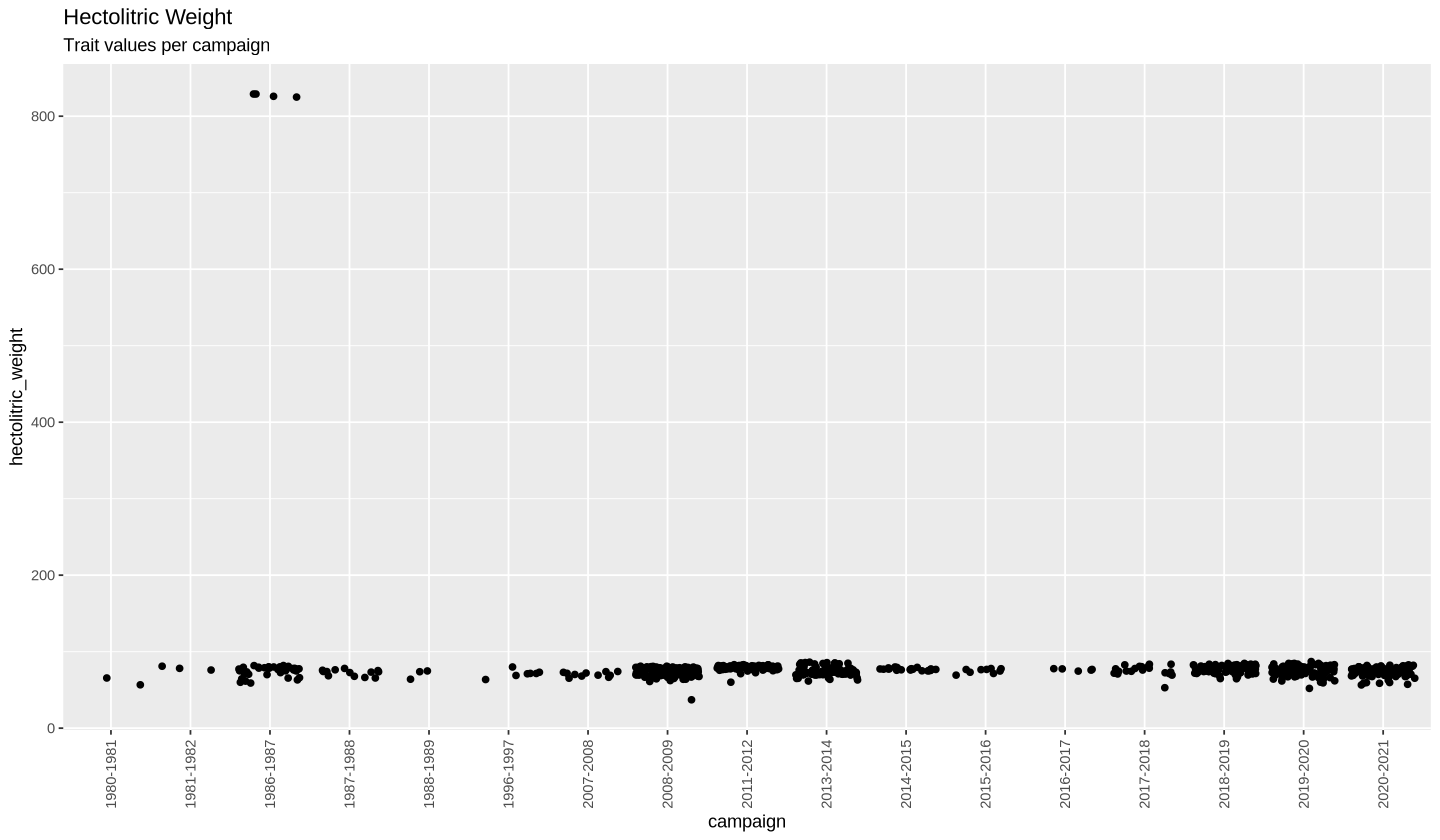

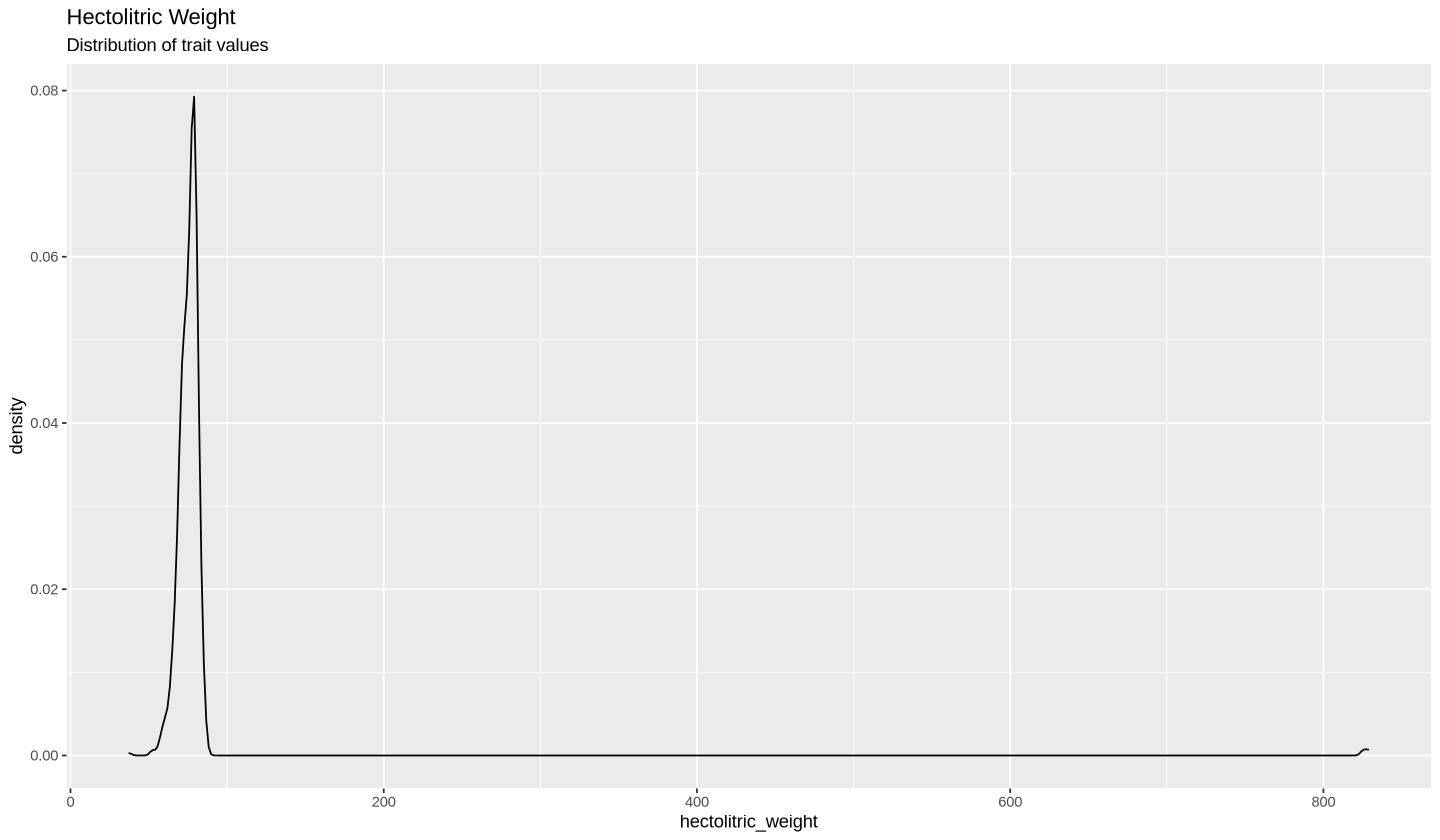

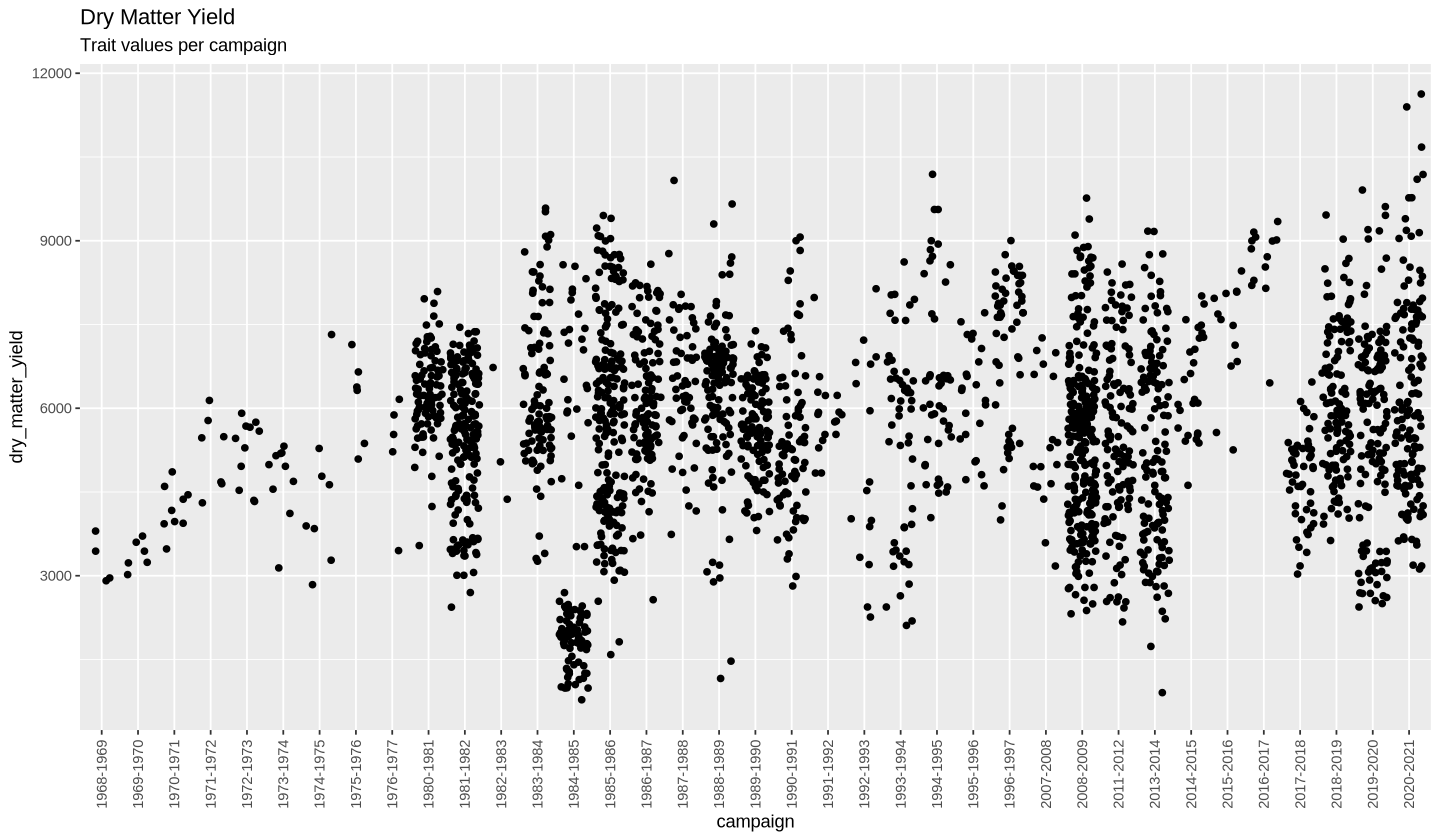

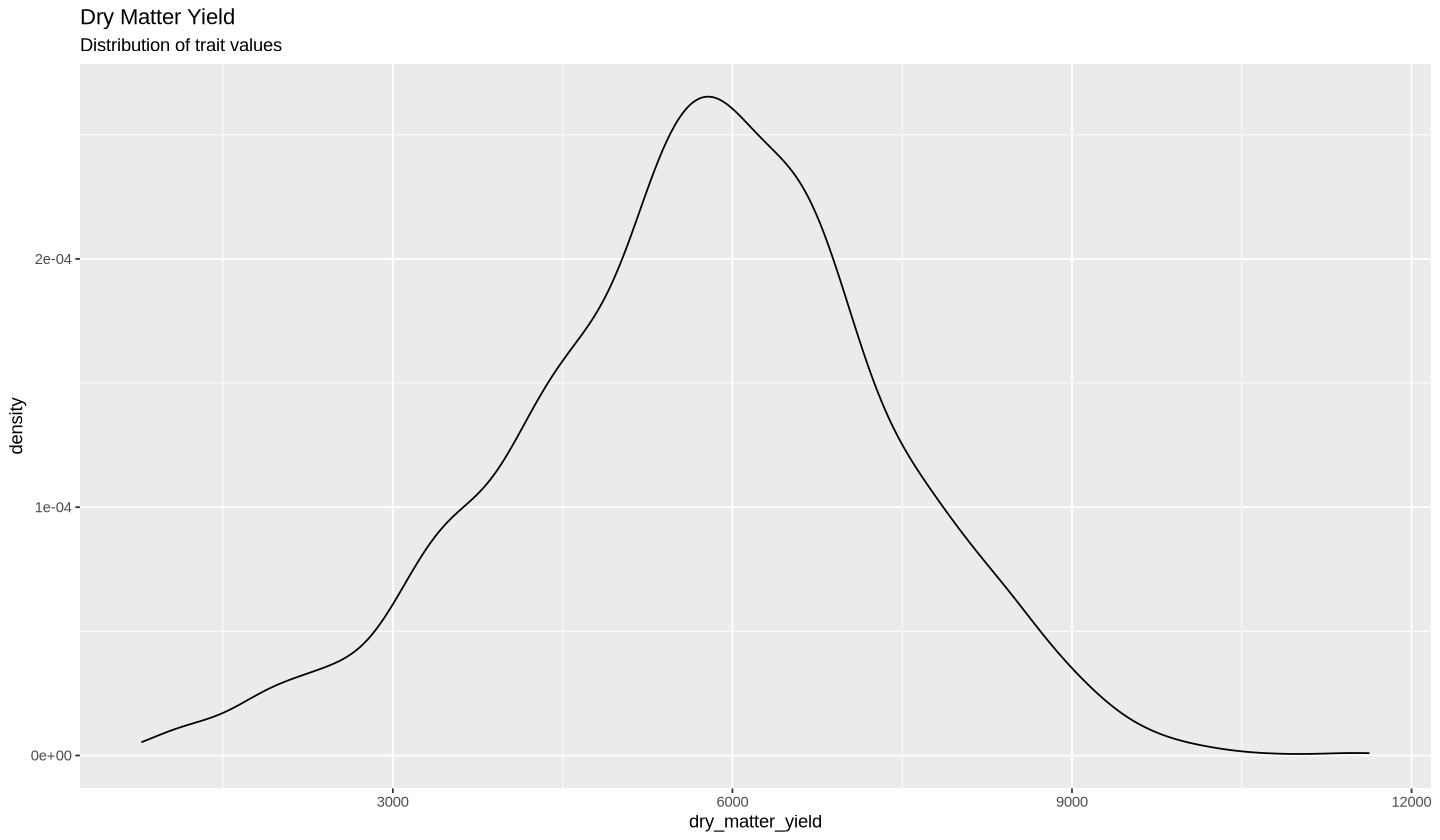

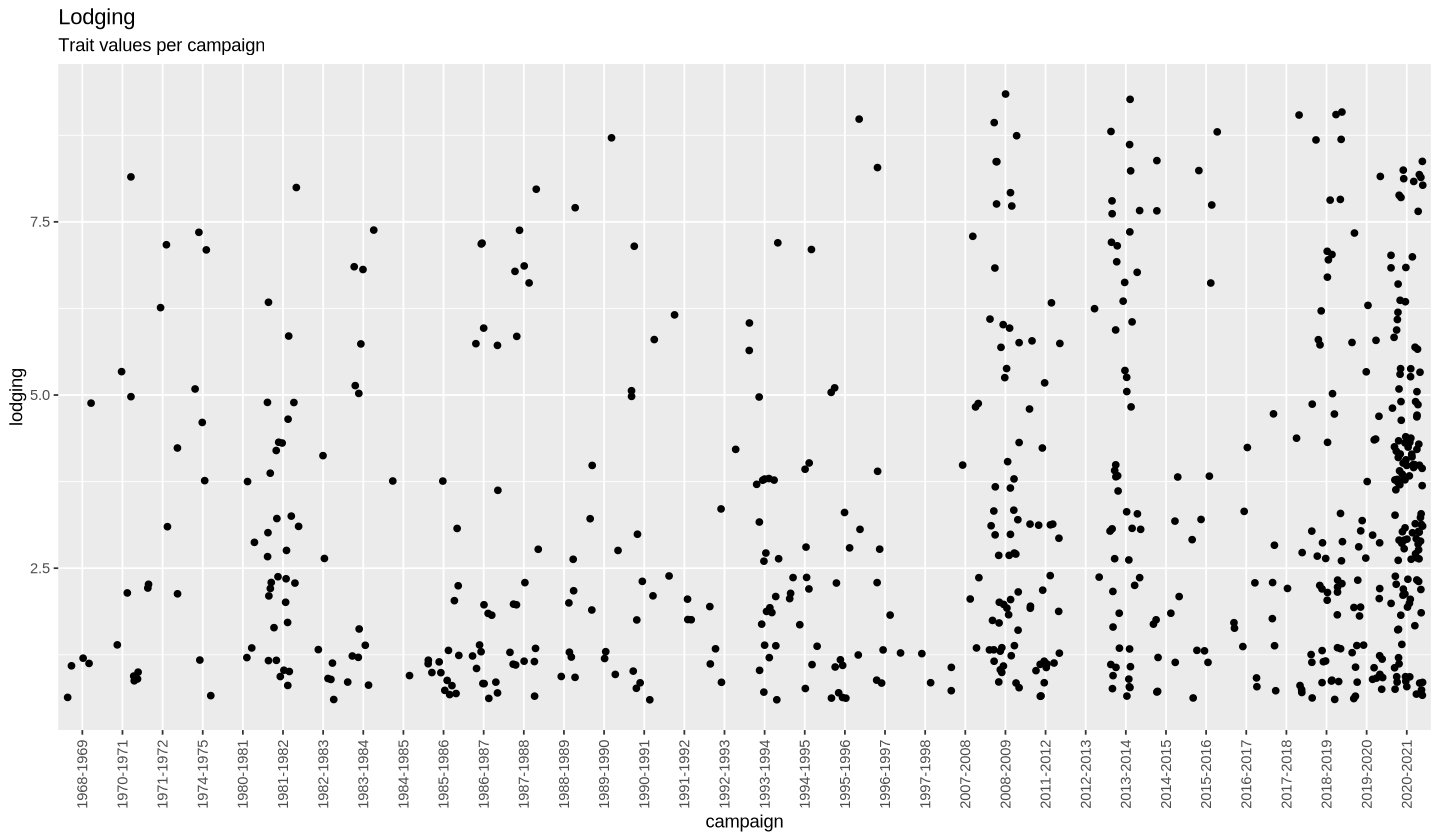

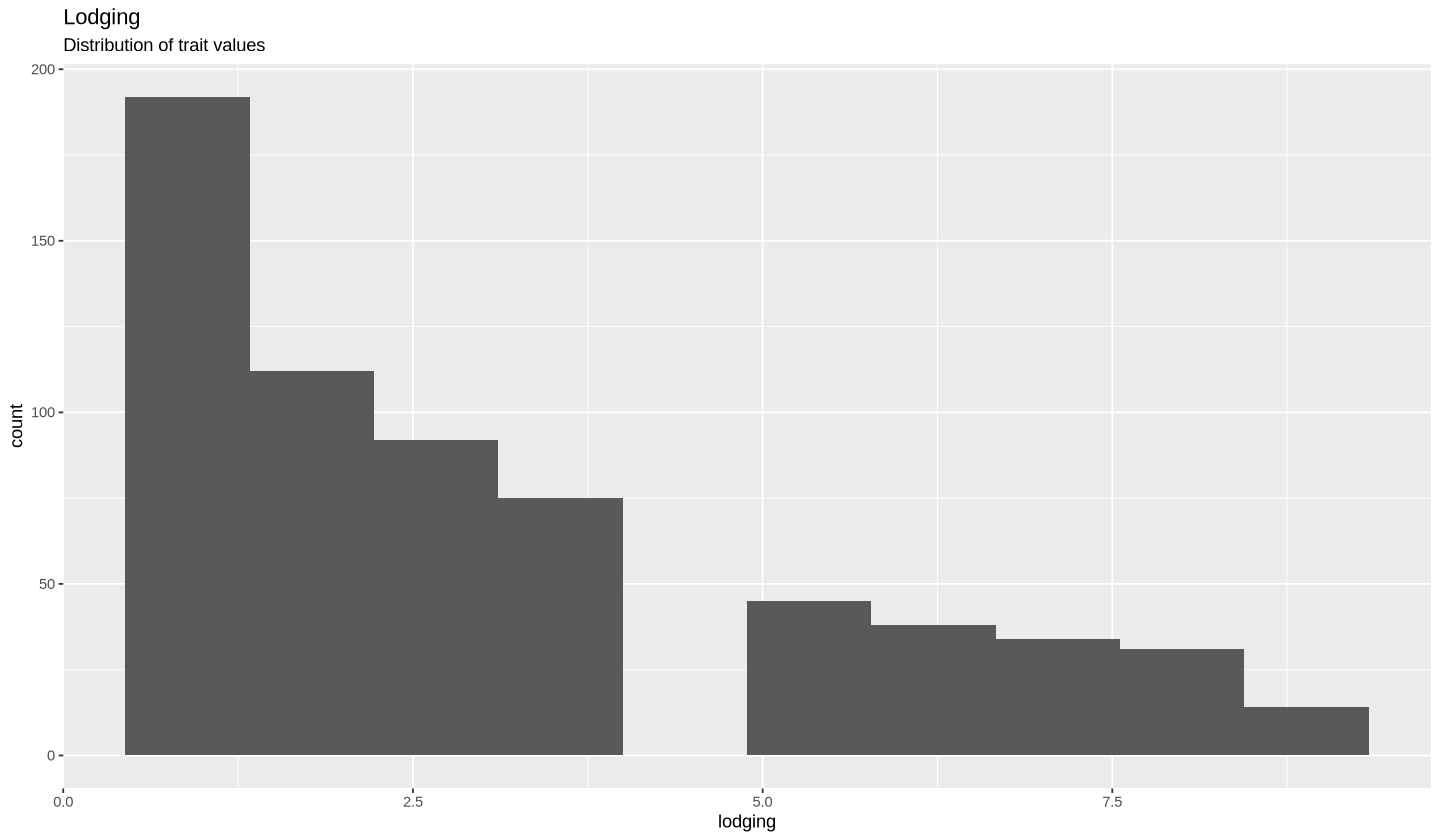

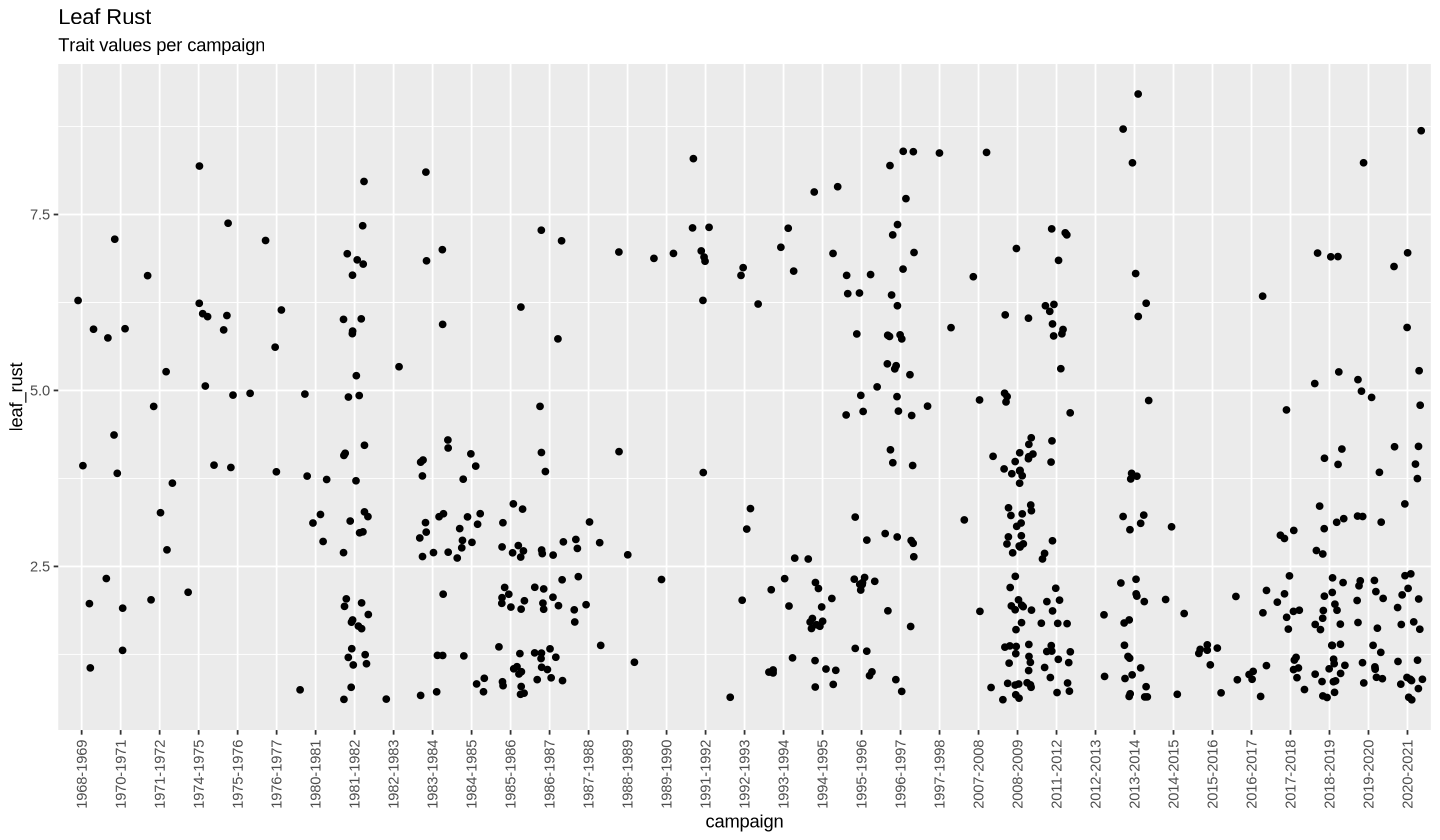

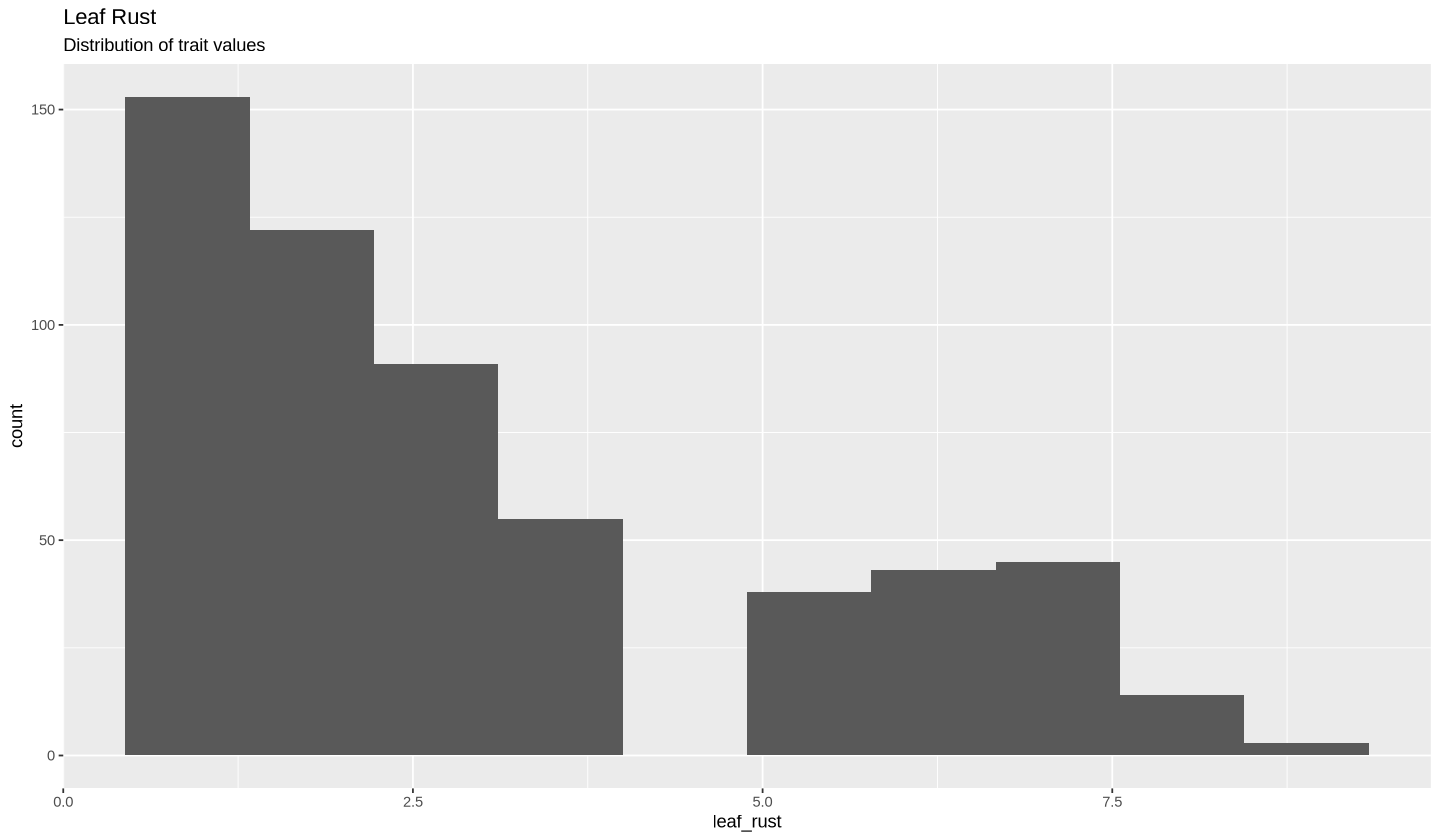

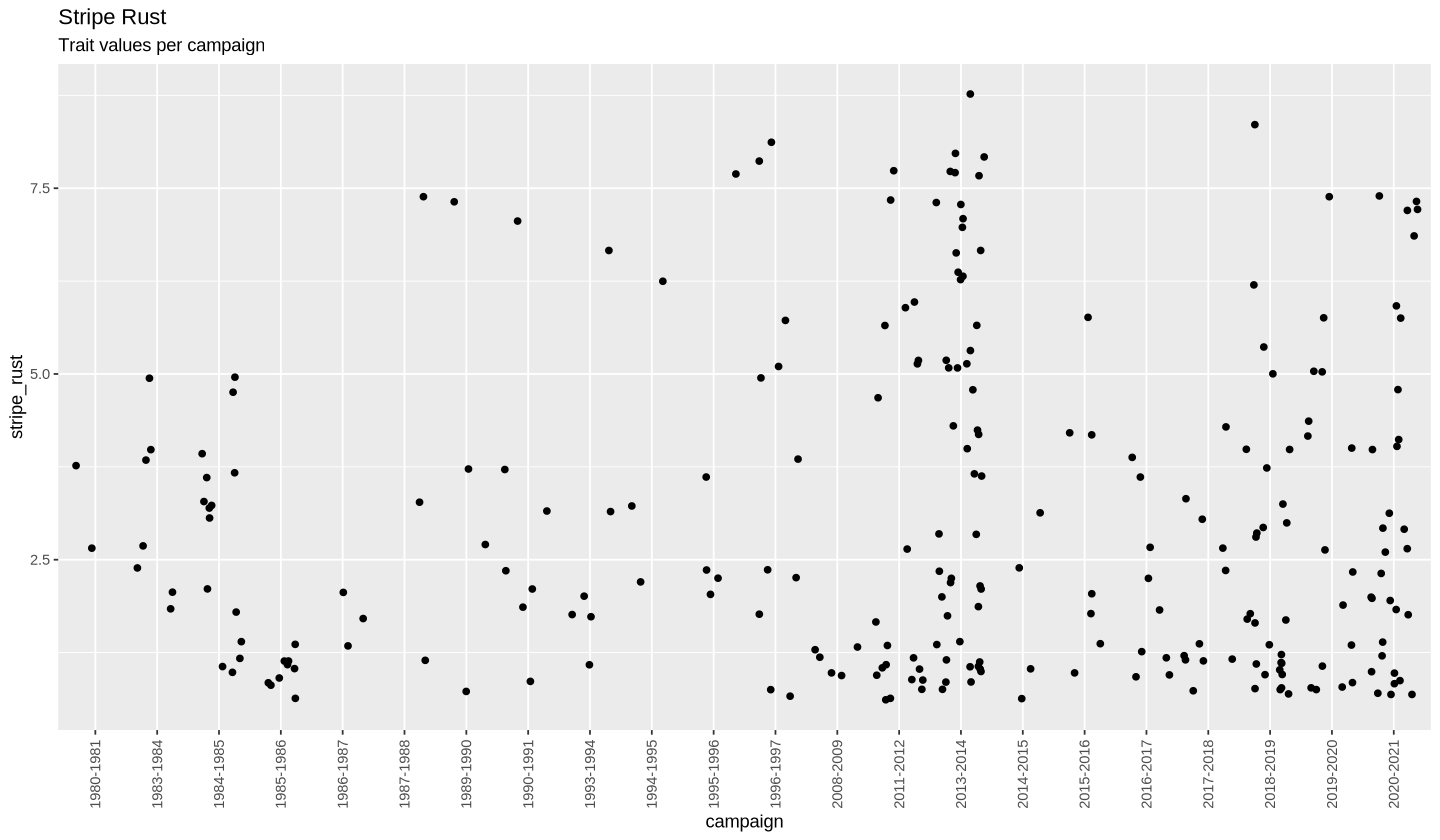

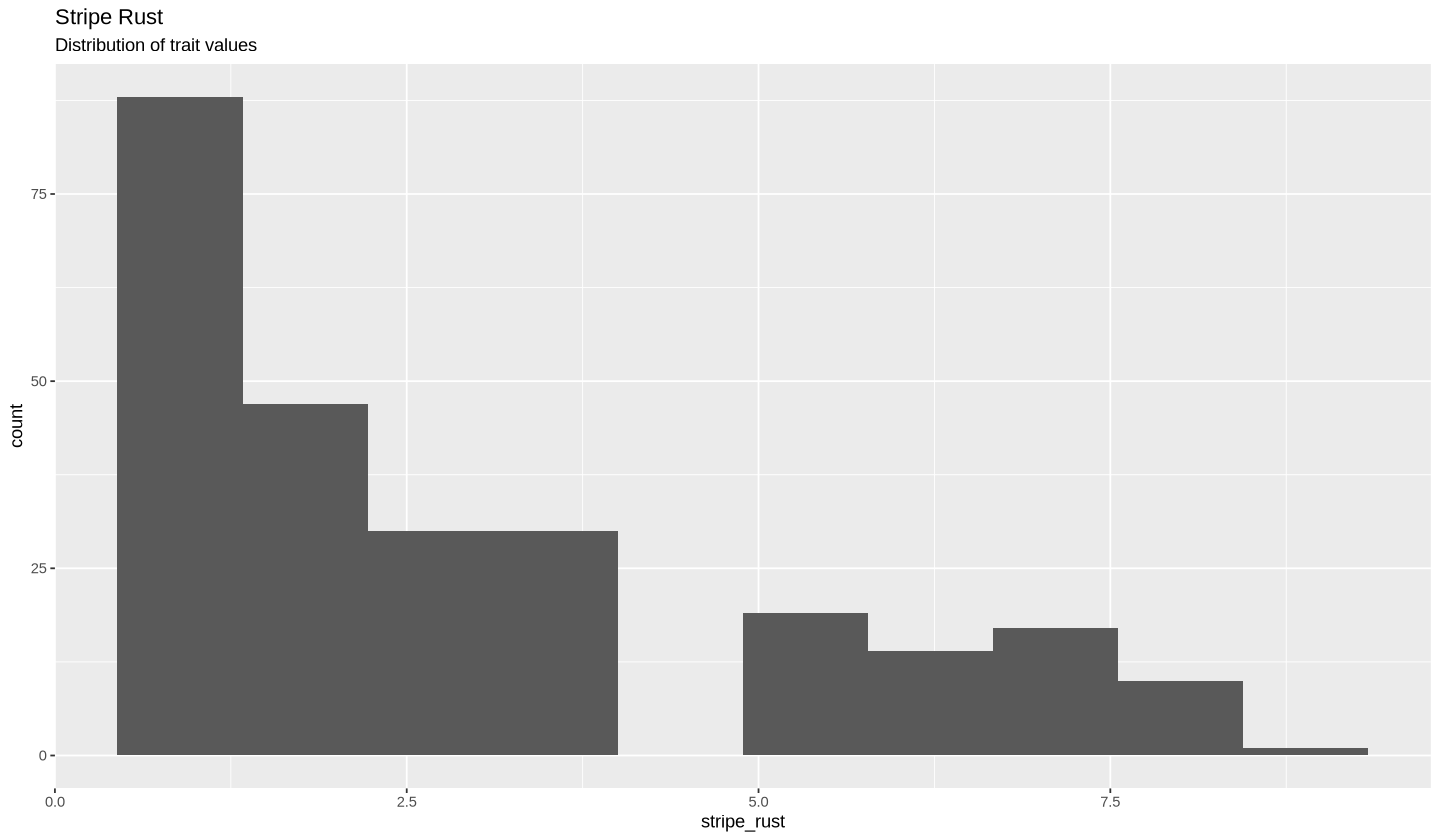

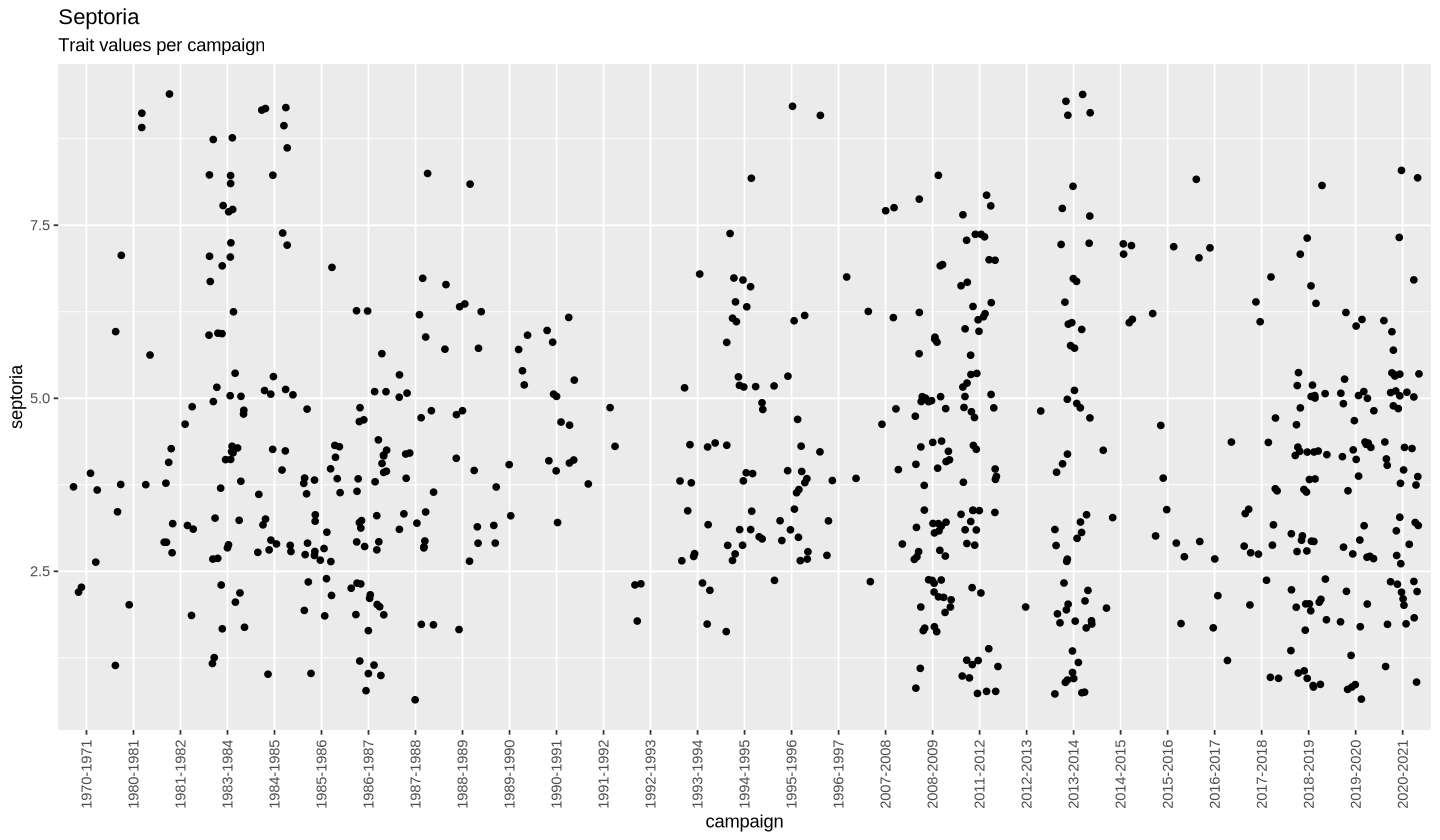

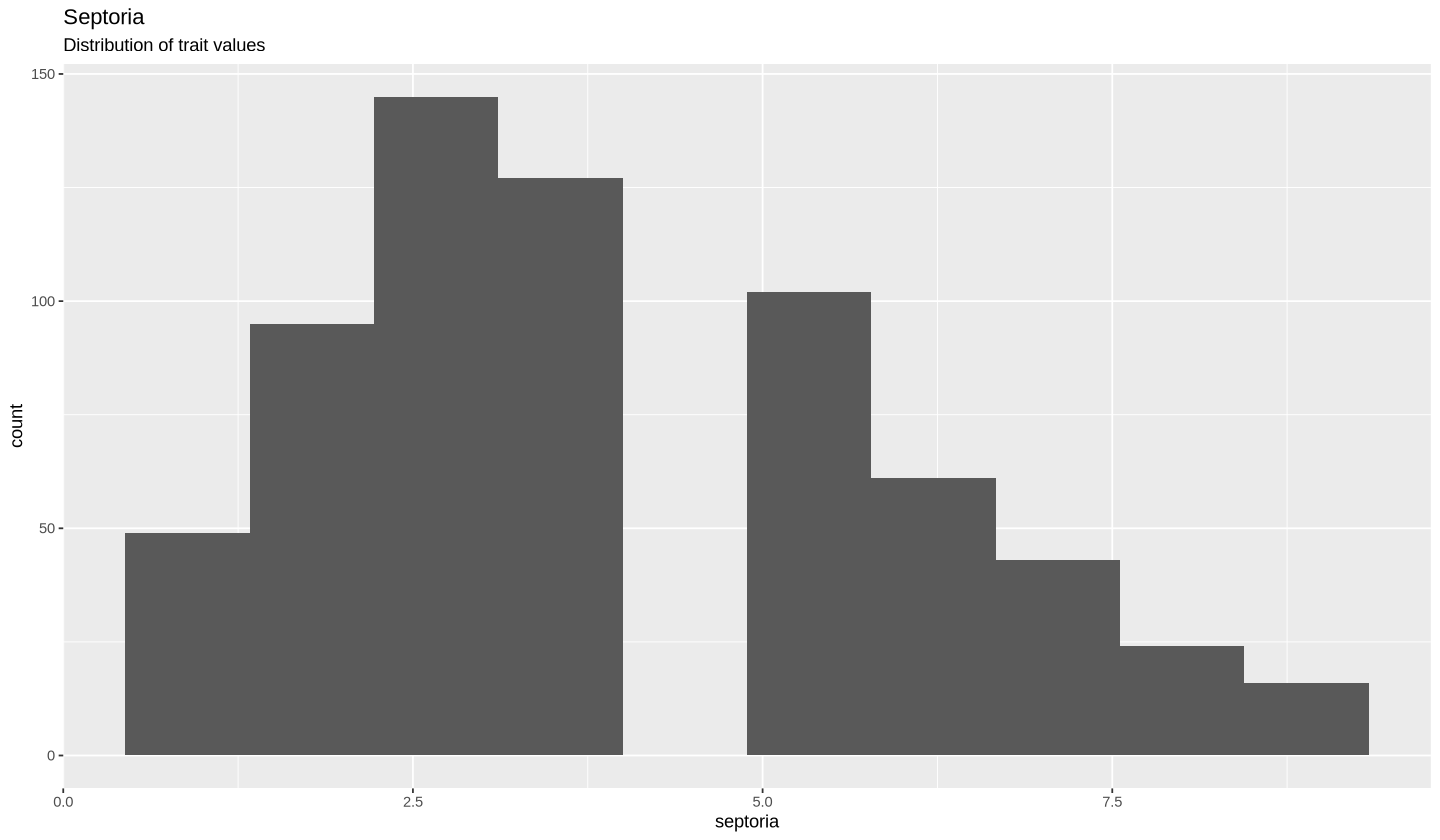

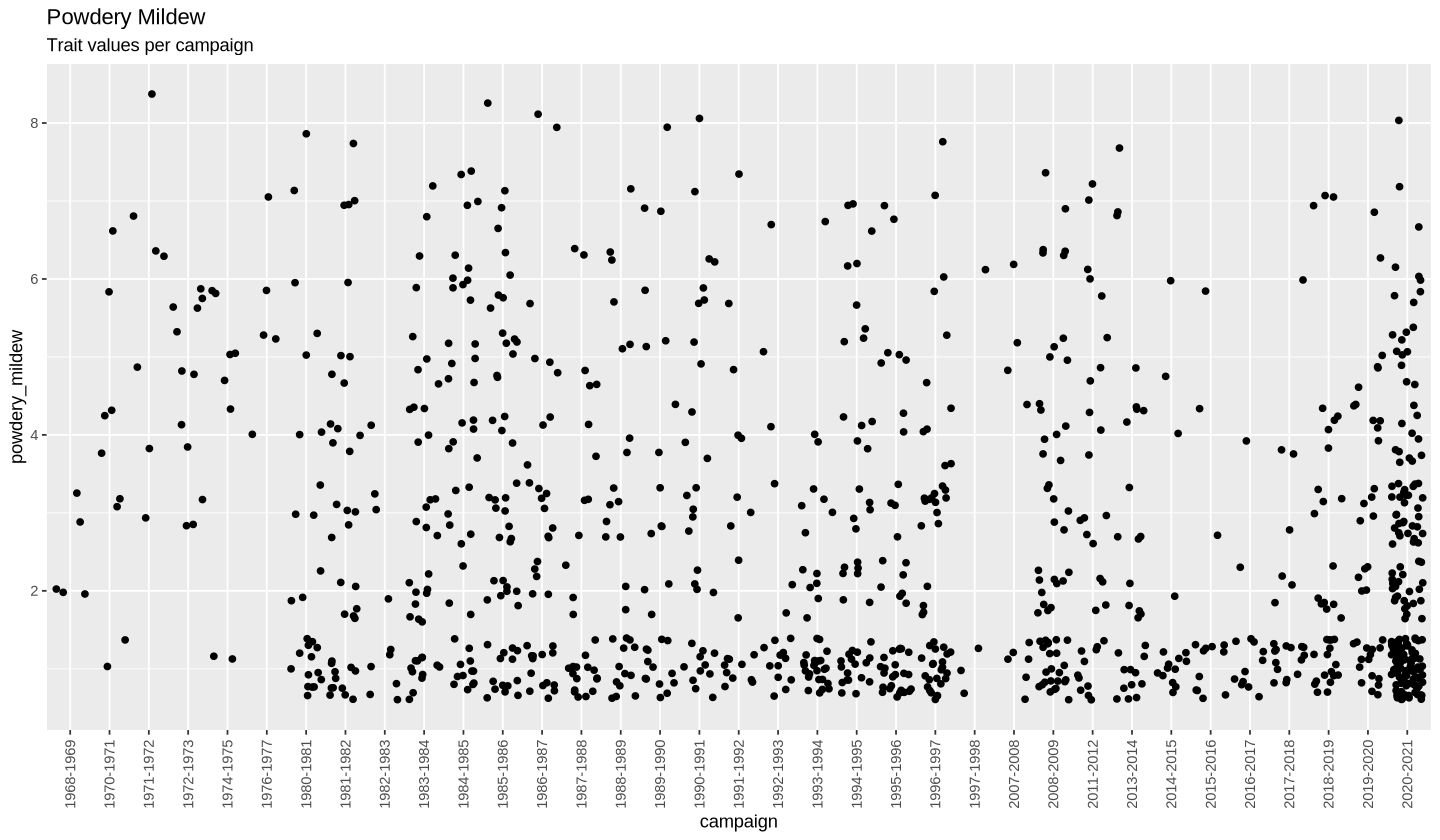

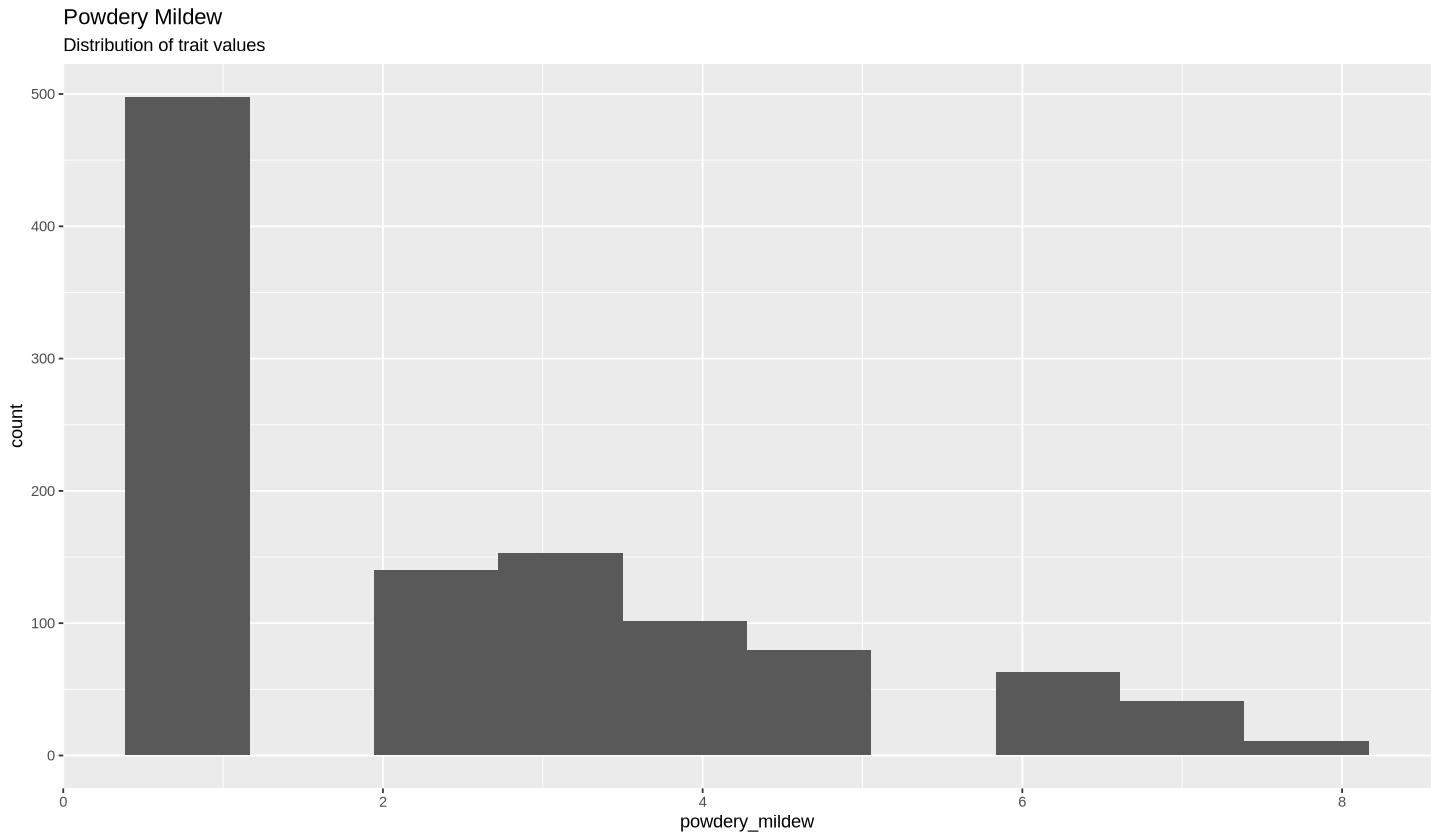

In [5]:
options(repr.plot.width=12, repr.plot.height=7)
data_sub_HT |> visualise_trait(geom_density())
data_sub_PH |> visualise_trait(geom_density())
data_sub_PD |> visualise_trait(geom_density())
data_sub_TKW |> visualise_trait(geom_density())
data_sub_HW |> visualise_trait(geom_density())
data_sub_DMY |> visualise_trait(geom_density())
data_sub_L |> visualise_trait(geom_histogram(bins=10))
data_sub_LR |> visualise_trait(geom_histogram(bins=10))
data_sub_SR |> visualise_trait(geom_histogram(bins=10))
data_sub_ST |> visualise_trait(geom_histogram(bins=10))
data_sub_PM |> visualise_trait(geom_histogram(bins=10))

## Extract and format the campaign effects

In [6]:
asreml_campaign_HT <- asreml(fixed = days_to_heading ~campaign, random = ~accenumb, 
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign),
                             data = data_sub_HT)

Online License checked out Mon Apr 22 16:37:02 2024
Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:02 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -4121.312           1.0   1773 16:37:02    0.0
 2     -4046.685           1.0   1773 16:37:02    0.0
 3     -3978.305           1.0   1773 16:37:02    0.0
 4     -3949.544           1.0   1773 16:37:02    0.0
 5     -3944.214           1.0   1773 16:37:02    0.0
 6     -3944.079           1.0   1773 16:37:02    0.0
 7     -3944.067           1.0   1773 16:37:02    0.0
 8     -3944.065           1.0   1773 16:37:02    0.0
 9     -3944.064           1.0   1773 16:37:02    0.0


In [7]:
asreml_campaign_PH <- asreml(fixed = plant_height ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_PH)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:03 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -6283.524           1.0   2154 16:37:03    0.0
 2     -6211.241           1.0   2154 16:37:03    0.0
 3     -6143.983           1.0   2154 16:37:03    0.0
 4     -6113.525           1.0   2154 16:37:03    0.0
 5     -6105.466           1.0   2154 16:37:03    0.0
 6     -6104.453           1.0   2154 16:37:03    0.0
 7     -6104.304           1.0   2154 16:37:03    0.0
 8     -6104.289           1.0   2154 16:37:03    0.0
 9     -6104.287           1.0   2154 16:37:03    0.0


Warning message in asreml(fixed = plant_height ~ campaign, random = ~accenumb, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration.”


In [8]:
asreml_campaign_PD <- asreml(fixed = plant_density ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_PD)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:03 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -9126.141           1.0   1703 16:37:03    0.0
 2     -9033.863           1.0   1703 16:37:03    0.0
 3     -8951.576           1.0   1703 16:37:03    0.0
 4     -8916.951           1.0   1703 16:37:03    0.0
 5     -8910.539           1.0   1703 16:37:03    0.0
 6     -8910.459           1.0   1703 16:37:03    0.0
 7     -8910.459           1.0   1703 16:37:03    0.0


In [9]:
asreml_campaign_TKW <- asreml(fixed = thousand_kernel_weight ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_TKW)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:03 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -2302.197           1.0   1055 16:37:03    0.0
 2     -2266.328           1.0   1055 16:37:03    0.0
 3     -2232.778           1.0   1055 16:37:03    0.0
 4     -2217.277           1.0   1055 16:37:03    0.0
 5     -2212.964           1.0   1055 16:37:03    0.0
 6     -2212.459           1.0   1055 16:37:03    0.0
 7     -2212.414           1.0   1055 16:37:03    0.0
 8     -2212.411           1.0   1055 16:37:03    0.0


Warning message in asreml(fixed = thousand_kernel_weight ~ campaign, random = ~accenumb, :
“Some components changed by more than 1% on the last iteration.”


In [10]:
asreml_campaign_HW <- asreml(fixed = hectolitric_weight ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_HW)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:03 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -1856.526           1.0    729 16:37:03    0.0 (2 restrained)
 2     -1774.074           1.0    729 16:37:03    0.0 (2 restrained)
 3     -1727.952           1.0    729 16:37:03    0.0
 4     -1710.944           1.0    729 16:37:03    0.0
 5     -1707.619           1.0    729 16:37:03    0.0
 6     -1707.560           1.0    729 16:37:03    0.0
 7     -1707.560           1.0    729 16:37:03    0.0


In [11]:
asreml_campaign_DMY <- asreml(fixed = dry_matter_yield ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_DMY)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:03 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -19583.52           1.0   2495 16:37:03    0.0 (1 restrained)
 2     -19450.40           1.0   2495 16:37:03    0.0
 3     -19329.07           1.0   2495 16:37:03    0.0
 4     -19276.78           1.0   2495 16:37:03    0.0
 5     -19266.86           1.0   2495 16:37:03    0.0
 6     -19266.70           1.0   2495 16:37:03    0.0
 7     -19266.70           1.0   2495 16:37:03    0.0


Warning message in asreml(fixed = dry_matter_yield ~ campaign, random = ~accenumb, :
“Some components changed by more than 1% on the last iteration.”


asreml_campaign_L <- asreml(fixed = lodging ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_L)
ERROR:
Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 15:58:06 2024
Log-likelihood decreased to  -inf ; trying with reduced updates (1.77892)
Error in asreml(fixed = lodging ~ campaign, random = ~accenumb, na.action = na.method(x = "omit", : Iteration failed; ifault: 2020

Traceback:

1. asreml(fixed = lodging ~ campaign, random = ~accenumb, na.action = na.method(x = "omit", 
 .     y = "omit"), residual = ~dsum(~id(units) | campaign), data = data_sub_L)

asreml_campaign_LR <- asreml(fixed = leaf_rust ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_LR)
ERROR:
Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 15:59:50 2024
1 singularities in the Average Information matrix.
Error in asreml(fixed = leaf_rust ~ campaign, random = ~accenumb, na.action = na.method(x = "omit", : Singularity in the Average Information matrix.

Traceback:

1. asreml(fixed = leaf_rust ~ campaign, random = ~accenumb, na.action = na.method(x = "omit", 
 .     y = "omit"), residual = ~dsum(~id(units) | campaign), data = data_sub_LR)

asreml_campaign_SR <- asreml(fixed = stripe_rust ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_SR)
Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 15:59:51 2024
Log-likelihood decreased to  -inf ; trying with reduced updates (1.77892)
Error in asreml(fixed = stripe_rust ~ campaign, random = ~accenumb, na.action = na.method(x = "omit", : Iteration failed; ifault: 2020

Traceback:

1. asreml(fixed = stripe_rust ~ campaign, random = ~accenumb, na.action = na.method(x = "omit", 
 .     y = "omit"), residual = ~dsum(~id(units) | campaign), dat

asreml_campaign_ST <- asreml(fixed = septoria ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_ST)
ERROR:
Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:02:12 2024
Log-likelihood decreased to  -inf ; trying with reduced updates (1.77892)
Error in asreml(fixed = septoria ~ campaign, random = ~accenumb, na.action = na.method(x = "omit", : Iteration failed; ifault: 2020

Traceback:

1. asreml(fixed = septoria ~ campaign, random = ~accenumb, na.action = na.method(x = "omit", 
 .     y = "omit"), residual = ~dsum(~id(units) | campaign), data = data_sub_ST)

In [12]:
asreml_campaign_PM <- asreml(fixed = powdery_mildew ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_PM)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:04 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -1285.442           1.0   1053 16:37:04    0.0
 2     -1232.958           1.0   1053 16:37:04    0.0
 3     -1184.527           1.0   1053 16:37:04    0.0
 4     -1163.948           1.0   1053 16:37:04    0.0
 5     -1160.190           1.0   1053 16:37:04    0.0
 6     -1160.145           1.0   1053 16:37:04    0.0
 7     -1160.145           1.0   1053 16:37:04    0.0


In [13]:
campaign_effect_HT <- get_campaign_effect(asreml_campaign_HT)
campaign_effect_PH <- get_campaign_effect(asreml_campaign_PH)
campaign_effect_PD <- get_campaign_effect(asreml_campaign_PD)
campaign_effect_TKW <- get_campaign_effect(asreml_campaign_TKW)
campaign_effect_HW <- get_campaign_effect(asreml_campaign_HW)
campaign_effect_DMY <- get_campaign_effect(asreml_campaign_DMY)
campaign_effect_PM <- get_campaign_effect(asreml_campaign_PM)

## Extract heterogeneous error variances

In [14]:
error_var_HT <- get_error_var(asreml_campaign_HT)
error_var_PH <- get_error_var(asreml_campaign_PH)
error_var_PD <- get_error_var(asreml_campaign_PD)
error_var_TKW <- get_error_var(asreml_campaign_TKW)
error_var_HW <- get_error_var(asreml_campaign_HW)
error_var_DMY <- get_error_var(asreml_campaign_DMY)
error_var_PM <- get_error_var(asreml_campaign_PM)

## Calculate and standardize the coefficient of variation (CV)

In [15]:
CV_df_HT <- make_CV_df(campaign_effect_HT, error_var_HT)
CV_df_PH <- make_CV_df(campaign_effect_PH, error_var_PH)
CV_df_PD <- make_CV_df(campaign_effect_PD, error_var_PD)
CV_df_TKW <- make_CV_df(campaign_effect_TKW, error_var_TKW)
CV_df_HW <- make_CV_df(campaign_effect_HW, error_var_HW)
CV_df_DMY <- make_CV_df(campaign_effect_DMY, error_var_DMY)
CV_df_PM <- make_CV_df(campaign_effect_PM, error_var_PM)

## Remove outlier campaigns

In [16]:
data_corrected_HT_I <- data_sub_HT |> correct_I(CV_df_HT)
data_corrected_PH_I <- data_sub_PH |> correct_I(CV_df_PH)
data_corrected_PD_I <- data_sub_PD |> correct_I(CV_df_PD)
data_corrected_TKW_I <- data_sub_TKW |> correct_I(CV_df_TKW)
data_corrected_HW_I <- data_sub_HW |> correct_I(CV_df_HW)
data_corrected_DMY_I <- data_sub_DMY |> correct_I(CV_df_DMY)
data_corrected_PM_I <- data_sub_PM |> correct_I(CV_df_PM)

0 outlier campaign(s) detected for trait days_to_heading
0 outlier campaign(s) detected for trait plant_height
1 outlier campaign(s) detected for trait plant_density: 2014-2015 
1 outlier campaign(s) detected for trait thousand_kernel_weight: 2012-2013 
1 outlier campaign(s) detected for trait hectolitric_weight: 1986-1987 
0 outlier campaign(s) detected for trait dry_matter_yield
1 outlier campaign(s) detected for trait powdery_mildew: 1997-1998 


## Residuals

In [17]:
asreml_res_HT <- asreml(fixed = days_to_heading ~ accenumb, random = ~ campaign,
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_HT_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:04 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -4063.208           1.0   1673 16:37:04    0.0
 2     -3962.751           1.0   1673 16:37:04    0.0
 3     -3866.326           1.0   1673 16:37:04    0.0
 4     -3818.636           1.0   1673 16:37:04    0.0
 5     -3804.098           1.0   1673 16:37:04    0.0
 6     -3801.678           1.0   1673 16:37:04    0.0
 7     -3801.125           1.0   1673 16:37:04    0.0
 8     -3800.741           1.0   1673 16:37:04    0.0 (1 restrained)
 9     -3800.293           1.0   1673 16:37:04    0.0 (1 restrained)
10     -3799.911           1.0   1673 16:37:04    0.0 (2 restrained)
11     -3796.725           1.0   1673 16:37:04    0.0 (4 restrained)
12     -3805.306           1.0   1673 16:37:04    0.0 (8 restrained)
13     -3911.140           1.0   1673 16:37:04    0.0 (7 restrained)


Warning message in asreml(fixed = days_to_heading ~ accenumb, random = ~campaign, :
“Log-likelihood not converged”
Warning message in asreml(fixed = days_to_heading ~ accenumb, random = ~campaign, :
“Some components changed by more than 1% on the last iteration.”


In [18]:
asreml_res_PH <- asreml(fixed = plant_height ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_PH_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:04 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -6028.590           1.0   2054 16:37:05    0.0
 2     -5949.616           1.0   2054 16:37:05    0.0 (2 restrained)
 3     -5880.443           1.0   2054 16:37:05    0.0
 4     -5845.995           1.0   2054 16:37:05    0.0
 5     -5835.233           1.0   2054 16:37:05    0.0
 6     -5833.474           1.0   2054 16:37:05    0.0
 7     -5833.245           1.0   2054 16:37:05    0.0
 8     -5833.213           1.0   2054 16:37:05    0.0
 9     -5833.205           1.0   2054 16:37:05    0.0
10     -5833.203           1.0   2054 16:37:05    0.0
11     -5833.202           1.0   2054 16:37:05    0.0
12     -5833.202           1.0   2054 16:37:05    0.0


In [19]:
asreml_res_PD <- asreml(fixed = plant_density ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_PD_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:05 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -8908.253           1.0   1653 16:37:05    0.0
 2     -8811.421           1.0   1653 16:37:05    0.0
 3     -8720.211           1.0   1653 16:37:05    0.0
 4     -8678.779           1.0   1653 16:37:05    0.0
 5     -8669.460           1.0   1653 16:37:05    0.0
 6     -8669.007           1.0   1653 16:37:05    0.0
 7     -8668.992           1.0   1653 16:37:05    0.0
 8     -8668.992           1.0   1653 16:37:05    0.0


In [20]:
asreml_res_TKW <- asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_TKW_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:05 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -2198.963           1.0   1013 16:37:05    0.0 (1 restrained)
 2     -2166.699           1.0   1013 16:37:05    0.0 (1 restrained)
 3     -2139.821           1.0   1013 16:37:05    0.0 (1 restrained)
 4     -2128.880           1.0   1013 16:37:05    0.0 (1 restrained)
 5     -2126.777           1.0   1013 16:37:05    0.0 (1 restrained)
 6     -2126.683           1.0   1013 16:37:05    0.0
 7     -2126.675           1.0   1013 16:37:05    0.0


Warning message in asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~campaign, :
“Some components changed by more than 1% on the last iteration.”


asreml_res_HW <- asreml(fixed = hectolitric_weight ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_HW_I)
ERROR:
Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:22:40 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -1501.943           1.0    657 16:22:40    0.0
1 singularities in the Average Information matrix.
Error in asreml(fixed = hectolitric_weight ~ accenumb, random = ~campaign, : Singularities in the average information matrix.

Traceback:

1. asreml(fixed = hectolitric_weight ~ accenumb, random = ~campaign, 
 .     na.action = na.method(x = "omit", y = "omit"), residual = ~dsum(~id(units) | 
 .         campaign), data = data_corrected_HW_I)

In [21]:
asreml_res_DMY <- asreml(fixed = dry_matter_yield ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_DMY_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:05 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -19300.40           1.0   2446 16:37:05    0.0
 2     -19154.00           1.0   2446 16:37:05    0.0
 3     -19017.72           1.0   2446 16:37:05    0.0 (1 restrained)
 4     -18954.97           1.0   2446 16:37:05    0.0 (1 restrained)
 5     -18940.15           1.0   2446 16:37:05    0.0 (1 restrained)
 6     -18939.12           1.0   2446 16:37:05    0.0 (1 restrained)
 7     -18939.08           1.0   2446 16:37:05    0.0 (1 restrained)
 8     -18939.08           1.0   2446 16:37:05    0.0


In [22]:
asreml_res_PM <- asreml(fixed = powdery_mildew ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_PM_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:05 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -1262.329           1.0    952 16:37:05    0.0
 2     -1205.373           1.0    952 16:37:05    0.0
 3     -1151.729           1.0    952 16:37:05    0.0
 4     -1127.319           1.0    952 16:37:05    0.0
 5     -1121.701           1.0    952 16:37:05    0.0
 6     -1121.308           1.0    952 16:37:05    0.0
 7     -1121.254           1.0    952 16:37:05    0.0
 8     -1121.243           1.0    952 16:37:05    0.0
 9     -1121.239           1.0    952 16:37:05    0.0
10     -1121.237           1.0    952 16:37:05    0.0
11     -1121.236           1.0    952 16:37:05    0.0


Warning message in asreml(fixed = powdery_mildew ~ accenumb, random = ~campaign, :
“Some components changed by more than 1% on the last iteration.”


13 outlier value(s) detected for trait Days To Heading 


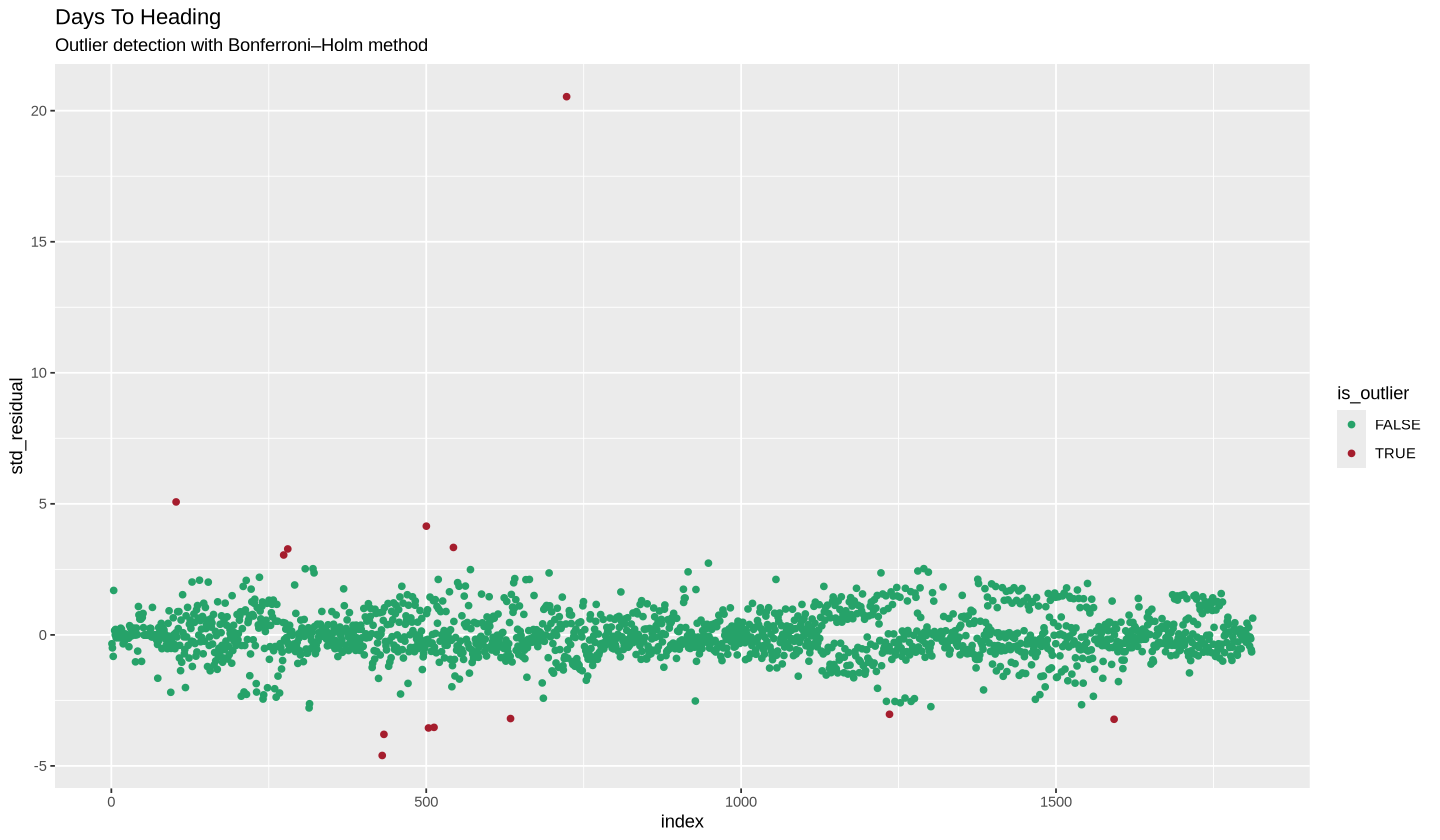

In [23]:
result_BH_HT <- make_BH_multtest(asreml_res_HT)

2 outlier value(s) detected for trait Plant Height 


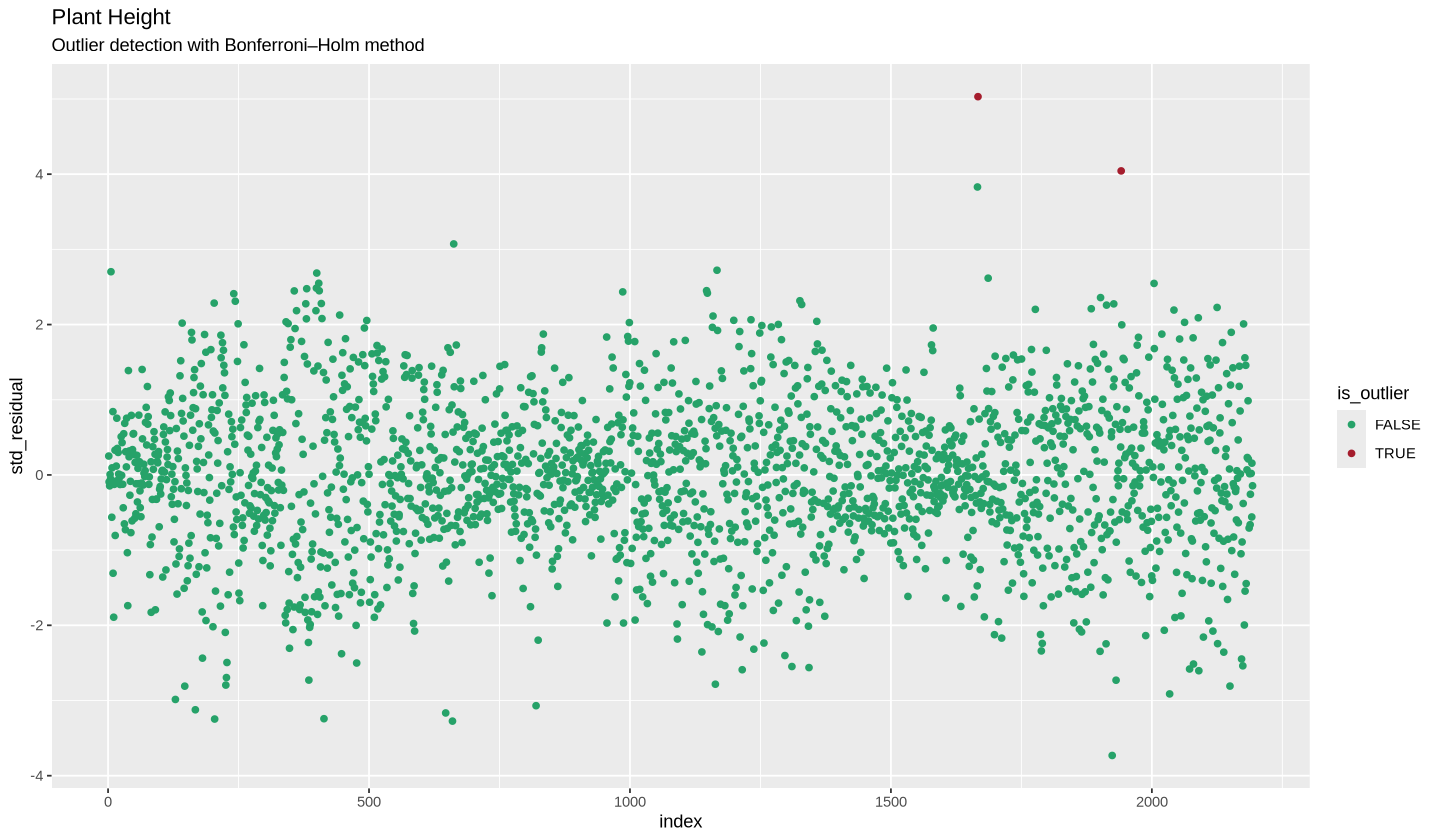

In [24]:
result_BH_PH <- make_BH_multtest(asreml_res_PH)

0 outlier value(s) detected for trait Plant Density 


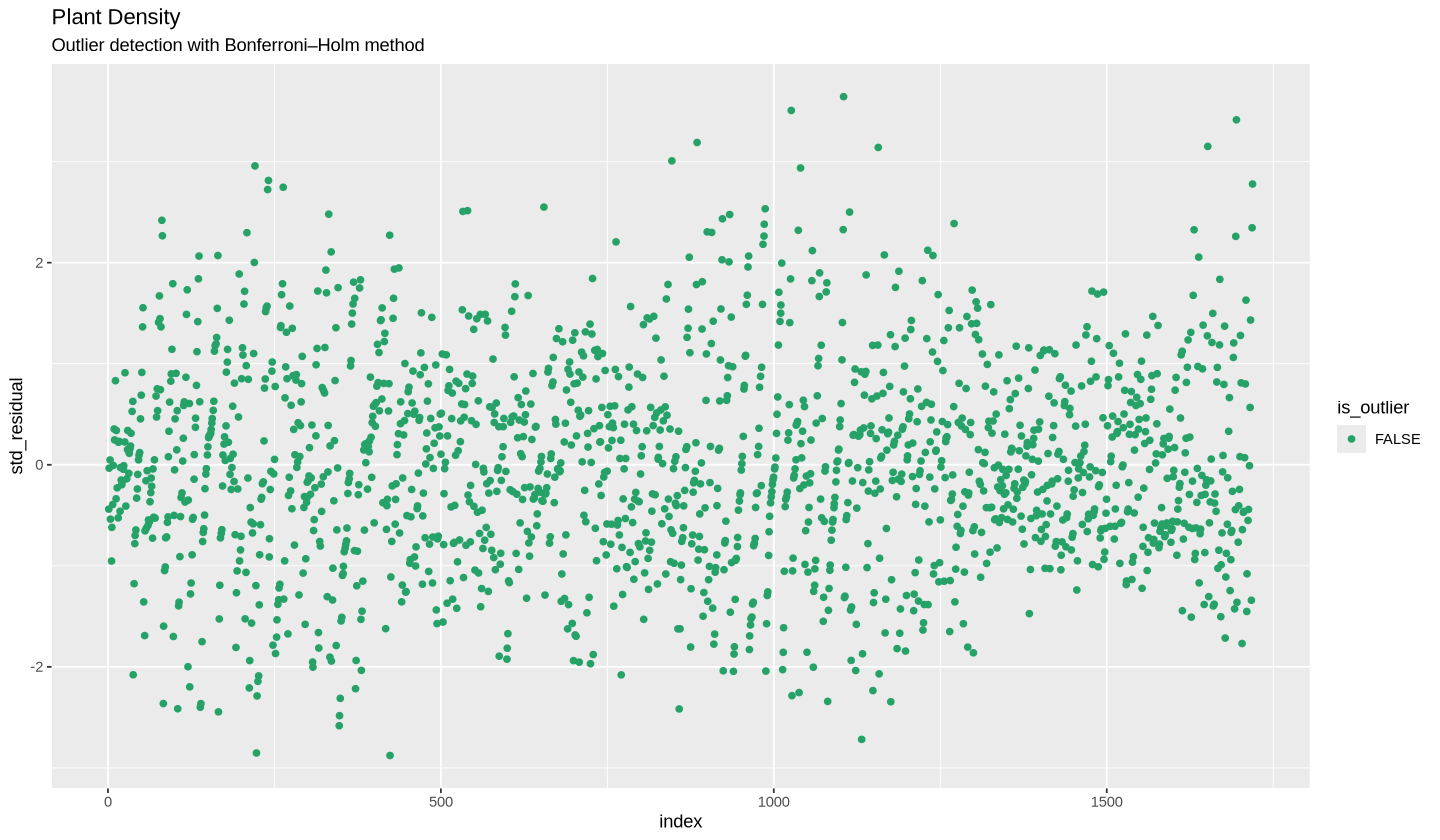

In [25]:
result_BH_PD <- make_BH_multtest(asreml_res_PD)

2 outlier value(s) detected for trait Thousand Kernel Weight 


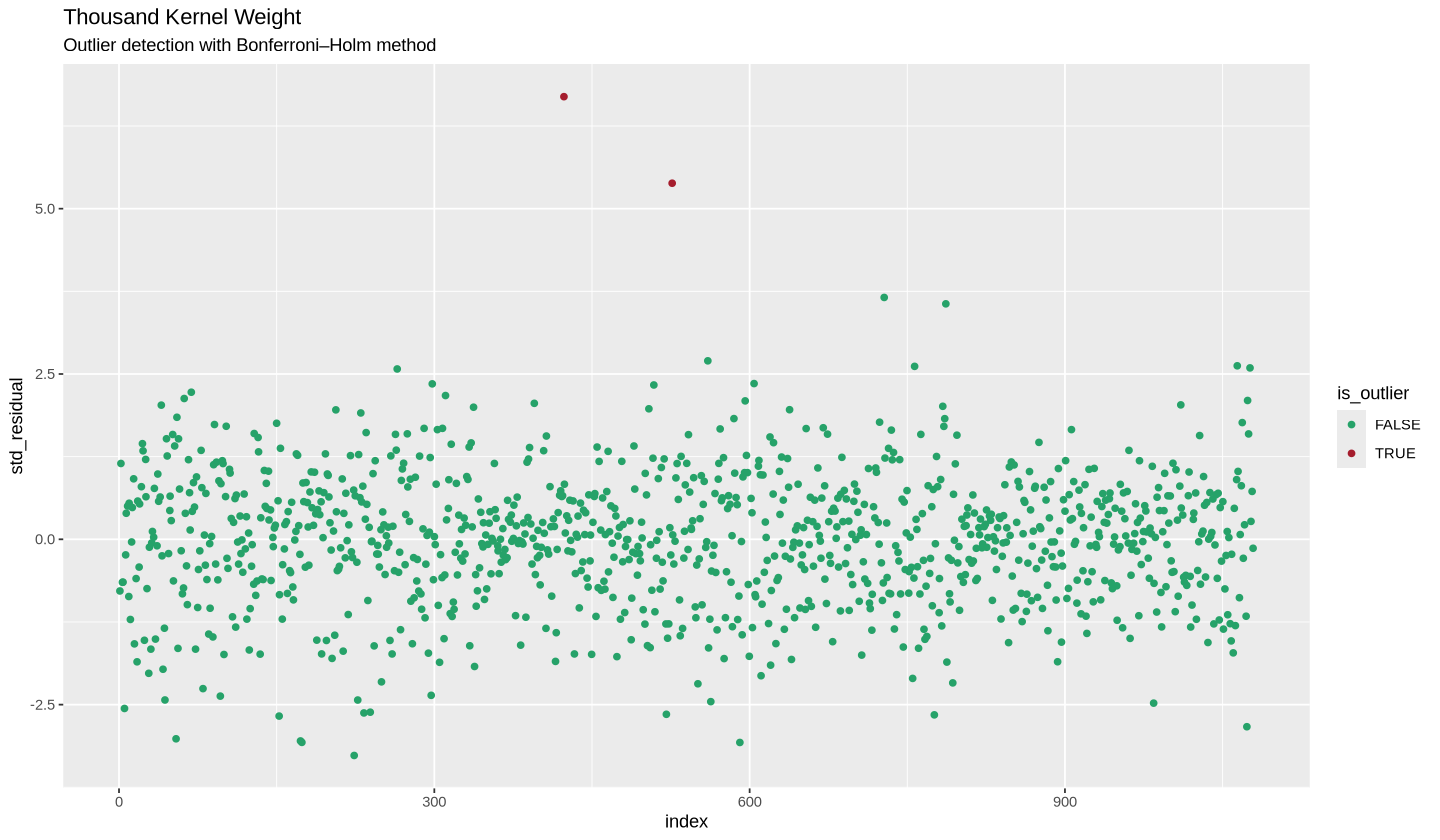

In [26]:
result_BH_TKW <- make_BH_multtest(asreml_res_TKW)

1 outlier value(s) detected for trait Dry Matter Yield 


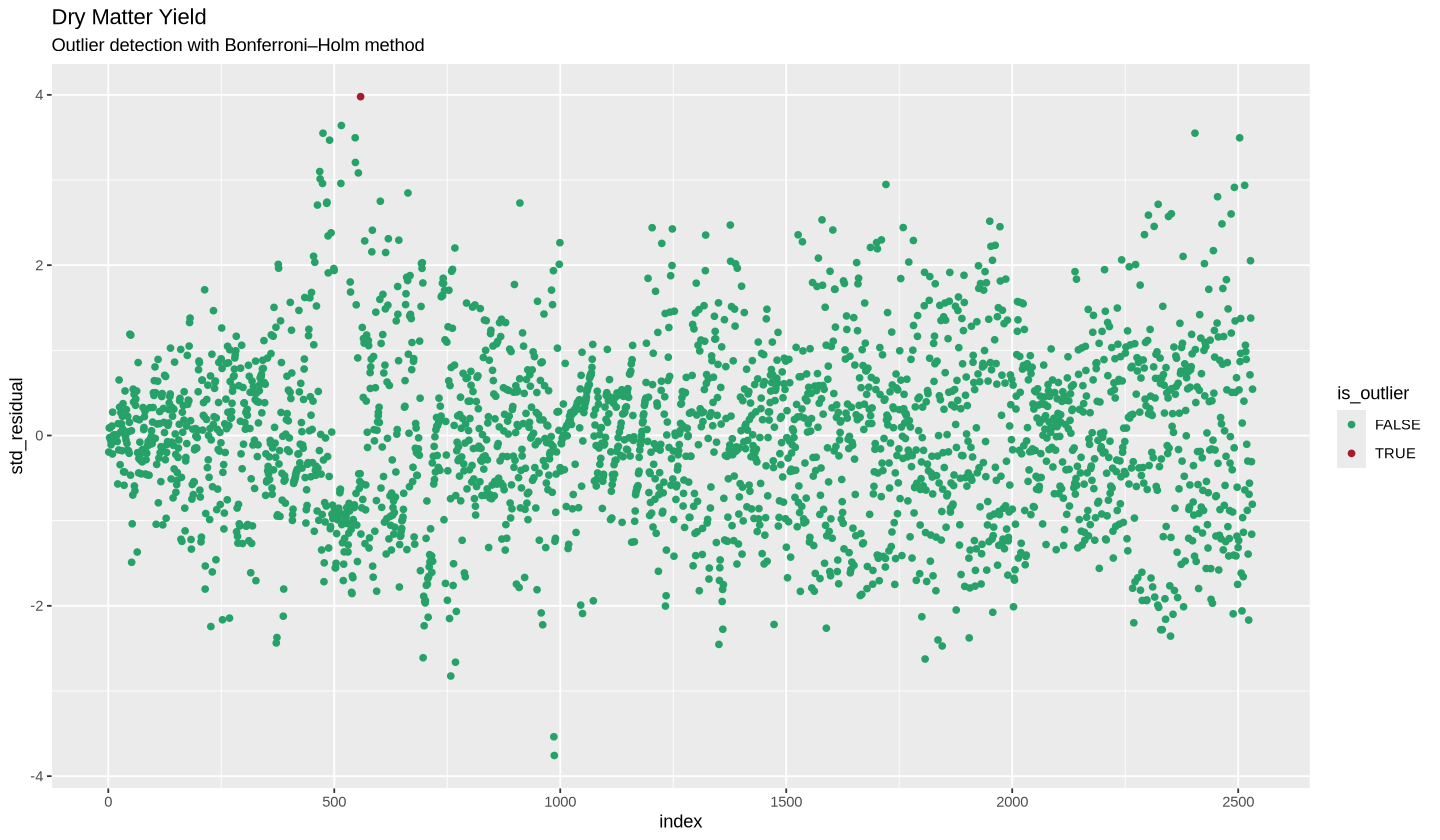

In [27]:
result_BH_DMY <- make_BH_multtest(asreml_res_DMY)

0 outlier value(s) detected for trait Powdery Mildew 


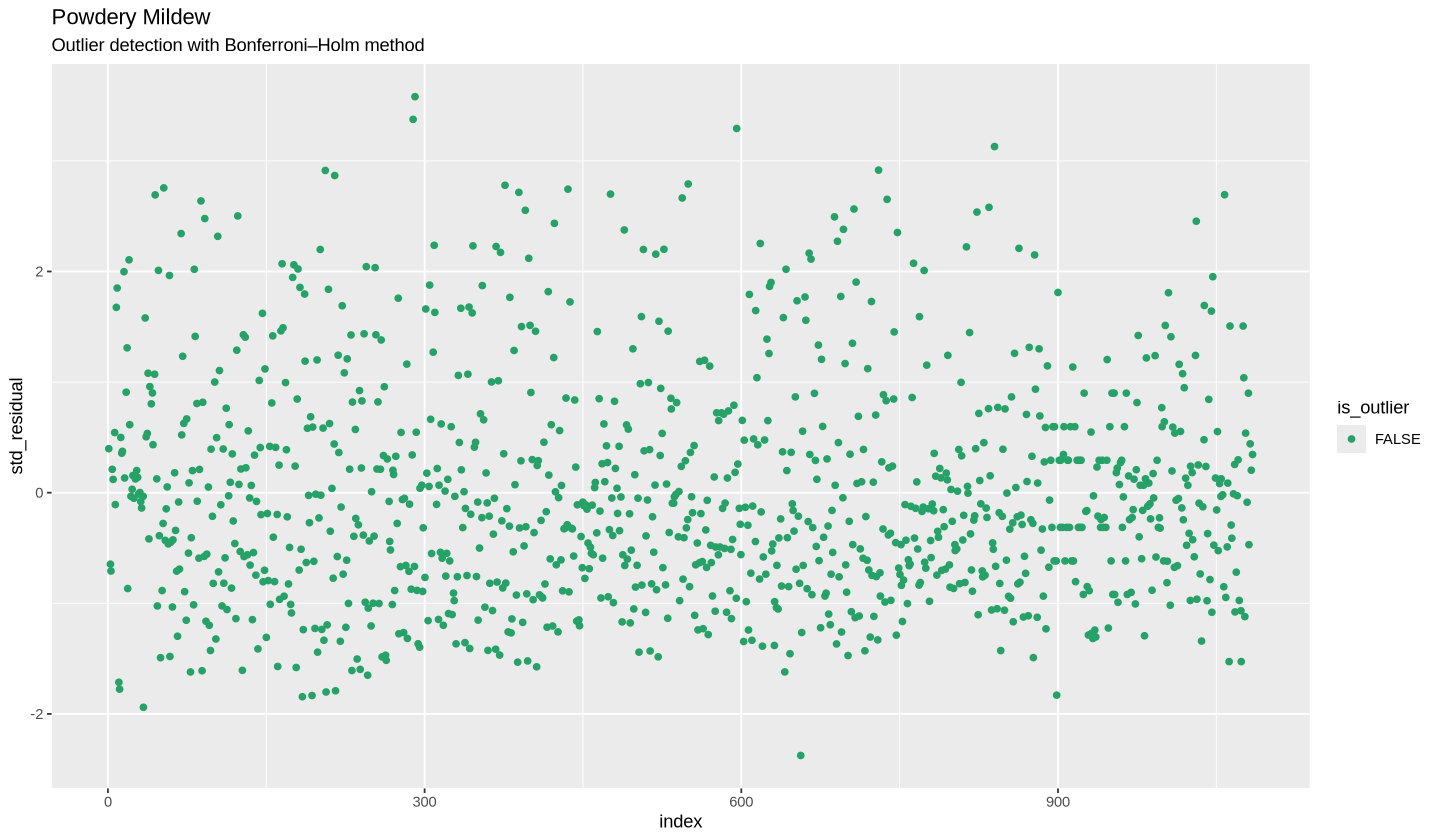

In [28]:
result_BH_PM <- make_BH_multtest(asreml_res_PM)

In [29]:
data_corrected_HT_II <- data_corrected_HT_I |> correct_II(result_BH_HT)
data_corrected_PH_II <- data_corrected_PH_I |> correct_II(result_BH_PH)
data_corrected_PD_II <- data_corrected_PD_I |> correct_II(result_BH_PD)
data_corrected_TKW_II <- data_corrected_TKW_I |> correct_II(result_BH_TKW)
data_corrected_DMY_II <- data_corrected_DMY_I |> correct_II(result_BH_DMY)
data_corrected_PM_II <- data_corrected_PM_I |> correct_II(result_BH_PM)

## Calculate heritability

In [30]:
asreml_res_h_HT <- asreml(days_to_heading ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_HT_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:08 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -4067.489           1.0   1798 16:37:08    0.0
 2     -3971.048           1.0   1798 16:37:08    0.0
 3     -3878.245           1.0   1798 16:37:08    0.0
 4     -3831.604           1.0   1798 16:37:08    0.0
 5     -3816.182           1.0   1798 16:37:08    0.0
 6     -3813.318           1.0   1798 16:37:08    0.0
 7     -3812.963           1.0   1798 16:37:08    0.0
 8     -3812.951           1.0   1798 16:37:08    0.0


Warning message in asreml(days_to_heading ~ 1, random = ~accenumb + campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration.”


In [31]:
asreml_res_h_PH <- asreml(plant_height ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_PH_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:08 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -6438.447           1.0   2190 16:37:08    0.0
 2     -6343.091           1.0   2190 16:37:08    0.0
 3     -6251.508           1.0   2190 16:37:08    0.0
 4     -6204.893           1.0   2190 16:37:08    0.0
 5     -6189.056           1.0   2190 16:37:08    0.0
 6     -6186.471           1.0   2190 16:37:08    0.0
 7     -6186.145           1.0   2190 16:37:08    0.0
 8     -6186.094           1.0   2190 16:37:08    0.0
 9     -6186.083           1.0   2190 16:37:08    0.0
10     -6186.080           1.0   2190 16:37:08    0.0
11     -6186.079           1.0   2190 16:37:08    0.0
12     -6186.079           1.0   2190 16:37:08    0.0


In [32]:
asreml_res_h_PD <- asreml(plant_density ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_PD_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:08 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -9184.873           1.0   1718 16:37:08    0.0
 2     -9087.702           1.0   1718 16:37:08    0.0
 3     -8996.369           1.0   1718 16:37:08    0.0
 4     -8955.099           1.0   1718 16:37:08    0.0
 5     -8945.796           1.0   1718 16:37:08    0.0
 6     -8945.261           1.0   1718 16:37:08    0.0
 7     -8945.239           1.0   1718 16:37:08    0.0
 8     -8945.239           1.0   1718 16:37:08    0.0


In [33]:
asreml_res_h_TKW <- asreml(thousand_kernel_weight ~1, random = ~accenumb + campaign, 
                    na.action = na.method(x="omit", y="omit"),
                    residual = ~dsum( ~id(units) | campaign), data = data_corrected_TKW_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:08 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -2312.265           1.0   1076 16:37:08    0.0
 2     -2273.117           1.0   1076 16:37:08    0.0
 3     -2235.810           1.0   1076 16:37:08    0.0
 4     -2217.477           1.0   1076 16:37:08    0.0
 5     -2211.684           1.0   1076 16:37:08    0.0
 6     -2210.906           1.0   1076 16:37:08    0.0 (1 restrained)
 7     -2210.839           1.0   1076 16:37:08    0.0 (1 restrained)
 8     -2210.836           1.0   1076 16:37:08    0.0 (1 restrained)
 9     -2210.835           1.0   1076 16:37:08    0.0 (1 restrained)


Warning message in asreml(thousand_kernel_weight ~ 1, random = ~accenumb + campaign, :
“Some components changed by more than 1% on the last iteration.”


In [34]:
asreml_res_h_DMY <- asreml(dry_matter_yield ~1, random = ~accenumb + campaign, 
                    na.action = na.method(x="omit", y="omit"),
                    residual = ~dsum( ~id(units) | campaign), data = data_corrected_DMY_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:08 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -19900.24           1.0   2530 16:37:09    0.0
 2     -19749.45           1.0   2530 16:37:09    0.0
 3     -19608.36           1.0   2530 16:37:09    0.0
 4     -19543.13           1.0   2530 16:37:09    0.0
 5     -19526.74           1.0   2530 16:37:09    0.0
 6     -19525.13           1.0   2530 16:37:09    0.0
 7     -19524.99           1.0   2530 16:37:09    0.0
 8     -19524.99           1.0   2530 16:37:09    0.0
 9     -19524.99           1.0   2530 16:37:09    0.0


Warning message in asreml(dry_matter_yield ~ 1, random = ~accenumb + campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration.”


In [35]:
asreml_res_h_PM <- asreml(powdery_mildew ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_PM_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:09 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -1312.270           1.0   1082 16:37:09    0.0
 2     -1253.636           1.0   1082 16:37:09    0.0
 3     -1198.883           1.0   1082 16:37:09    0.0
 4     -1174.647           1.0   1082 16:37:09    0.0
 5     -1169.463           1.0   1082 16:37:09    0.0
 6     -1169.075           1.0   1082 16:37:09    0.0
 7     -1168.972           1.0   1082 16:37:09    0.0
 8     -1168.947           1.0   1082 16:37:09    0.0
 9     -1168.942           1.0   1082 16:37:09    0.0
10     -1168.940           1.0   1082 16:37:09    0.0
11     -1168.940           1.0   1082 16:37:09    0.0


In [36]:
quality_HT <- get_quality(data_sub_HT, asreml_res_h_HT)
quality_PH <- get_quality(data_sub_PH, asreml_res_h_PH)
quality_PD <- get_quality(data_sub_PD, asreml_res_h_PD)
quality_TKW <- get_quality(data_sub_TKW, asreml_res_h_TKW)
quality_DMY <- get_quality(data_sub_DMY, asreml_res_h_DMY)
quality_PM <- get_quality(data_sub_PM, asreml_res_h_PM)

quality_all = bind_rows(quality_HT, quality_PH, quality_PD, quality_TKW, quality_DMY, quality_PM) |> 
                    mutate(across(-1, \(x) round(x, 3)))
write_csv(quality_all,"NARDI_wheat_data_quality.csv")

days_to_heading heritability: 72.4 %
plant_height heritability: 92.2 %
plant_density heritability: 60.1 %
thousand_kernel_weight heritability: 91.2 %
dry_matter_yield heritability: 69.1 %
powdery_mildew heritability: 30.6 %


## Run linear mixed model with outlier corrected data

In [37]:
asreml_data_HT <- asreml(days_to_heading ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_HT_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:09 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -3849.352           1.0   1660 16:37:09    0.0
 2     -3751.944           1.0   1660 16:37:09    0.0
 3     -3657.988           1.0   1660 16:37:09    0.0
 4     -3610.306           1.0   1660 16:37:09    0.0
 5     -3594.546           1.0   1660 16:37:09    0.0
 6     -3591.731           1.0   1660 16:37:09    0.0
 7     -3591.488           1.0   1660 16:37:09    0.0
 8     -3591.377           1.0   1660 16:37:09    0.0
 9     -3591.347           1.0   1660 16:37:09    0.0
10     -3591.341           1.0   1660 16:37:09    0.0
11     -3591.338           1.0   1660 16:37:09    0.0
12     -3591.337           1.0   1660 16:37:09    0.0
13     -3591.337           1.0   1660 16:37:09    0.0


Warning message in asreml(days_to_heading ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Log-likelihood not converged”
Warning message in asreml(days_to_heading ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration.”


In [38]:
asreml_data_PH <- asreml(plant_height ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_PH_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:09 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -6005.666           1.0   2052 16:37:09    0.0
 2     -5927.560           1.0   2052 16:37:09    0.0 (2 restrained)
 3     -5858.973           1.0   2052 16:37:09    0.0
 4     -5824.489           1.0   2052 16:37:09    0.0
 5     -5813.043           1.0   2052 16:37:09    0.0
 6     -5810.374           1.0   2052 16:37:09    0.0
 7     -5809.373           1.0   2052 16:37:09    0.0
 8     -5809.001           1.0   2052 16:37:09    0.0
 9     -5808.924           1.0   2052 16:37:09    0.0
10     -5808.912           1.0   2052 16:37:09    0.0
11     -5808.910           1.0   2052 16:37:09    0.0
12     -5808.910           1.0   2052 16:37:09    0.0


In [39]:
asreml_data_PD <- asreml(plant_density ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_PD_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:10 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -8908.253           1.0   1653 16:37:10    0.0
 2     -8811.421           1.0   1653 16:37:10    0.0
 3     -8720.211           1.0   1653 16:37:10    0.0
 4     -8678.779           1.0   1653 16:37:10    0.0
 5     -8669.460           1.0   1653 16:37:10    0.0
 6     -8669.007           1.0   1653 16:37:10    0.0
 7     -8668.992           1.0   1653 16:37:10    0.0
 8     -8668.992           1.0   1653 16:37:10    0.0


In [40]:
asreml_data_TKW <- asreml(thousand_kernel_weight ~accenumb, random = ~campaign, 
                          na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                          data = data_corrected_TKW_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:10 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -2158.364           1.0   1011 16:37:10    0.0 (1 restrained)
 2     -2127.776           1.0   1011 16:37:10    0.0 (1 restrained)
 3     -2102.562           1.0   1011 16:37:10    0.0 (1 restrained)
 4     -2092.328           1.0   1011 16:37:10    0.0 (1 restrained)
 5     -2090.351           1.0   1011 16:37:10    0.0 (1 restrained)
 6     -2090.259           1.0   1011 16:37:10    0.0
 7     -2090.251           1.0   1011 16:37:10    0.0


Warning message in asreml(thousand_kernel_weight ~ accenumb, random = ~campaign, :
“Some components changed by more than 1% on the last iteration.”


In [41]:
asreml_data_DMY <- asreml(dry_matter_yield ~accenumb, random = ~campaign, 
                          na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                          data = data_corrected_DMY_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:10 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -19290.05           1.0   2445 16:37:10    0.0
 2     -19143.54           1.0   2445 16:37:10    0.0
 3     -19007.12           1.0   2445 16:37:10    0.0 (1 restrained)
 4     -18944.23           1.0   2445 16:37:10    0.0 (1 restrained)
 5     -18929.30           1.0   2445 16:37:10    0.0 (1 restrained)
 6     -18928.24           1.0   2445 16:37:10    0.0 (1 restrained)
 7     -18928.19           1.0   2445 16:37:10    0.0 (1 restrained)
 8     -18928.19           1.0   2445 16:37:10    0.0


In [42]:
asreml_data_PM <- asreml(powdery_mildew ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_PM_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Mon Apr 22 16:37:10 2024
          LogLik        Sigma2     DF     wall    cpu
 1     -1262.145           1.0    952 16:37:10    0.0
 2     -1205.257           1.0    952 16:37:10    0.0
 3     -1151.681           1.0    952 16:37:10    0.0
 4     -1127.309           1.0    952 16:37:10    0.0
 5     -1121.700           1.0    952 16:37:10    0.0
 6     -1121.308           1.0    952 16:37:10    0.0
 7     -1121.254           1.0    952 16:37:10    0.0
 8     -1121.243           1.0    952 16:37:10    0.0
 9     -1121.239           1.0    952 16:37:10    0.0
10     -1121.237           1.0    952 16:37:10    0.0
11     -1121.236           1.0    952 16:37:10    0.0


Warning message in asreml(powdery_mildew ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration.”


## Extract BLUEs and create output file

In [43]:
BLUEs_HT <- get_BLUEs(asreml_data_HT)
BLUEs_PH <- get_BLUEs(asreml_data_PH)
BLUEs_PD <- get_BLUEs(asreml_data_PD)
BLUEs_TKW <- get_BLUEs(asreml_data_TKW)
BLUEs_DMY <- get_BLUEs(asreml_data_DMY)
BLUEs_PM <- get_BLUEs(asreml_data_PM)


BLUE_all <- genotypes |> left_join(BLUEs_HT, by="genotype") |> 
                        left_join(BLUEs_PH, by="genotype") |> 
                        left_join(BLUEs_PD, by="genotype") |> 
                        left_join(BLUEs_TKW, by="genotype") |> 
                        left_join(BLUEs_DMY, by="genotype") |> 
                        left_join(BLUEs_PM, by="genotype") |>
                        arrange(genotype) |> mutate(across(-1, \(x) round(x, 2)))

write_csv(BLUE_all,"NARDI_wheat_BLUE_values.csv")
summary(BLUE_all)

   genotype         days_to_heading_BLUE plant_height_BLUE plant_density_BLUE
 Length:750         Min.   :133.3        Min.   : 73.12    Min.   :479.0     
 Class :character   1st Qu.:137.4        1st Qu.: 89.30    1st Qu.:567.5     
 Mode  :character   Median :139.3        Median : 96.36    Median :593.5     
                    Mean   :139.6        Mean   : 97.02    Mean   :594.2     
                    3rd Qu.:141.3        3rd Qu.:104.36    3rd Qu.:618.1     
                    Max.   :158.6        Max.   :129.29    Max.   :835.3     
                    NA's   :611          NA's   :611       NA's   :684       
 thousand_kernel_weight_BLUE dry_matter_yield_BLUE powdery_mildew_BLUE
 Min.   :31.11               Min.   :3045          Min.   :0.880      
 1st Qu.:40.02               1st Qu.:5246          1st Qu.:1.715      
 Median :42.90               Median :5742          Median :2.260      
 Mean   :42.56               Mean   :5614          Mean   :2.386      
 3rd Qu.:45.22       

In [44]:
library(rmarkdown)
convert_ipynb("NARDI_historic_wheat_data_analysis.ipynb")

In [45]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Fedora Linux 40.20240419.n.0 (Silverblue)

Matrix products: default
BLAS/LAPACK: /var/home/erwan/.conda/envs/R/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Europe/Paris
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rmarkdown_2.26      asreml_4.1.0.154    Matrix_1.6-5       
 [4] multtest_2.58.0     Biobase_2.62.0      BiocGenerics_0.48.1
 [7] lubridate_1.9.3     forcats_1.0.0       stringr_1.5.1      
[10] dplyr_1.1.4         purrr_1.0.2         readr_2.1.5        
[13] t